In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from itertools import chain
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.metrics import AUC
from tensorflow.keras.models import Model


# paths
train_jpeg_dir = '/content/drive/MyDrive/satellite_imagery/train-jpg/train-jpg'
train_csv_file = '/content/drive/MyDrive/satellite_imagery/train_v2.csv'
test_jpeg_dir = '/content/drive/MyDrive/satellite_imagery/test-jpg/test-jpg'
test_additional_jpeg_dir = '/content/drive/MyDrive/satellite_imagery/test-jpg-additional/test-jpg-additional'
img_resize = (128, 128)
validation_split = 0.2
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

# labels
labels_df = pd.read_csv(train_csv_file)

# set unique labels
labels = sorted(set(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values])))
labels_map = {label: idx for idx, label in enumerate(labels)}  # Map labels to indices
num_classes = len(labels_map)

# labels to one-hot vectors
def encode_tags(tags_str):
    tags = tags_str.split(' ')
    targets = np.zeros(num_classes, dtype='float32')
    for tag in tags:
        targets[labels_map[tag]] = 1.0
    return targets

labels_df['targets'] = labels_df['tags'].apply(encode_tags)

# split into train test validation groups
train_df, val_df = train_test_split(labels_df, test_size=validation_split, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


In [ ]:
from PIL import Image

# Load and preprocess images
def _load_image(path_str):
    try:
        # Decode file path
        path_str = path_str.decode('utf-8')
        with Image.open(path_str) as img:
            img = img.convert('RGB')
            img = img.resize(img_resize)
            img_array = np.array(img).astype(np.float32) / 255.0
            return (img_array * 2.0) - 1.0  # Normalize pixels to [-1, 1]
    except Exception as e:
        print(f"Error loading image {path_str}: {e}")
        return np.zeros([img_resize[0], img_resize[1], 3], dtype=np.float32)

# Load / resize images
def load_and_preprocess_image_numpy(path, label):
    image = tf.numpy_function(func=_load_image, inp=[path], Tout=tf.float32)
    image.set_shape([img_resize[0], img_resize[1], 3]) #3 color channels
    return image, label

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def augment_image(image, label):
    return data_augmentation(image), label

# Create dataset function
def create_dataset_numpy(df, image_dir, training=True):
    image_paths = df['image_name'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg")).tolist()
    labels = np.stack(df['targets'].values)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_and_preprocess_image_numpy, num_parallel_calls=AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1000).map(augment_image, num_parallel_calls=AUTOTUNE)
    return dataset.batch(batch_size).prefetch(AUTOTUNE)

# Create training and validation datasets
train_dataset_numpy = create_dataset_numpy(train_df, train_jpeg_dir, training=True)
val_dataset_numpy = create_dataset_numpy(val_df, train_jpeg_dir, training=False)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load pretrained model ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True  # unfreeze base model to train on our data

# custom classification
x = base_model.output #take output from ResNet50 model
x = GlobalAveragePooling2D()(x) #reduce size a little
x = Dropout(0.5)(x) #prevent overfitting
x = Dense(256, activation='relu')(x) #add non-linearity with ReLu
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='sigmoid')(x)  # multilabel classification

model = Model(inputs=base_model.input, outputs=outputs)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy', #best for multilabel classification models
    metrics=[tf.keras.metrics.BinaryAccuracy(), AUC()] #binary accuracy measures accuracy for each class #AUC for imbalanced class accuracy
)

model.summary() #visualize ResNet layers and our added layers

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,116,625 (92.00 MB)

 Trainable params: 24,063,505 (91.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
#training
history = model.fit(
    train_dataset_numpy,
    validation_data=val_dataset_numpy,
    epochs=11,
    verbose=1
)

Epoch 1/11
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 1522s 644ms/step - auc: 0.7853 - binary_accuracy: 0.7829 - loss: 0.4844 - val_auc: 0.9710 - val_binary_accuracy: 0.9470 - val_loss: 0.1450
Epoch 2/11
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 90s 43ms/step - auc: 0.9488 - binary_accuracy: 0.9294 - loss: 0.1928 - val_auc: 0.9792 - val_binary_accuracy: 0.9564 - val_loss: 0.1203
Epoch 3/11
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 90s 43ms/step - auc: 0.9627 - binary_accuracy: 0.9420 - loss: 0.1627 - val_auc: 0.9821 - val_binary_accuracy: 0.9593 - val_loss: 0.1118
Epoch 4/11
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 90s 44ms/step - auc: 0.9689 - binary_accuracy: 0.9480 - loss: 0.1469 - val_auc: 0.9814 - val_binary_accuracy: 0.9597 - val_loss: 0.1197
Epoch 5/11
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 89s 43ms/step - auc: 0.9728 - binary_accuracy: 0.9509 - loss: 0.1377 - val_auc: 0.9838 - val_binary_accuracy: 0.9608 - val_loss: 0.1109
Epoch 6/11
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 89s 43ms/step - auc: 0.9759 - binary_accuracy: 0.9538 - loss: 0.1

In [ ]:
# find class-wise accuracies
def calculate_class_accuracies(predictions, true_labels, labels_map):
    """
    Calculate and return class-wise accuracies.
    Args:
        predictions: Binary predictions from the model.
        true_labels: True labels from the dataset.
        labels_map: Dictionary mapping class names to indices.
    Returns:
        Dictionary with class-wise accuracies.
    """
    accuracies = {}
    for class_name, class_idx in labels_map.items():
        true_positive = np.sum((predictions[:, class_idx] == 1) & (true_labels[:, class_idx] == 1))
        total_positive = np.sum(true_labels[:, class_idx])
        accuracies[class_name] = true_positive / total_positive if total_positive > 0 else 0.0
    return accuracies

# make sure dataset is ready for evaluation
for val_images, val_labels in val_dataset_numpy.take(1):
    # Predict probabilities with trained model
    val_predictions = model.predict(val_images)

    # change raw probabilities into binary predictions with threshold = 0.5
    val_binary_predictions = (val_predictions > 0.5).astype(int)

    # class-wise accuracies
    class_accuracies = calculate_class_accuracies(val_binary_predictions, val_labels.numpy(), labels_map)

print("Class Accuracies:")
for class_name, accuracy in class_accuracies.items():
    print(f"{class_name}: {accuracy:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Class Accuracies:
agriculture: 1.00
artisinal_mine: 0.00
bare_ground: 0.00
blooming: 0.00
blow_down: 0.00
clear: 0.89
cloudy: 1.00
conventional_mine: 0.00
cultivation: 0.00
habitation: 0.33
haze: 0.00
partly_cloudy: 1.00
primary: 1.00
road: 0.83
selective_logging: 0.00
slash_burn: 0.00
water: 0.67


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# find class-wise metrics
def calculate_class_metrics(predictions, true_labels, labels_map):
    """
    Calculate precision, recall, F1-score, and accuracy for each class.
    """
    metrics = {}
    for class_name, class_idx in labels_map.items():
        true_positive = np.sum((predictions[:, class_idx] == 1) & (true_labels[:, class_idx] == 1))
        false_positive = np.sum((predictions[:, class_idx] == 1) & (true_labels[:, class_idx] == 0))
        false_negative = np.sum((predictions[:, class_idx] == 0) & (true_labels[:, class_idx] == 1))
        total_positive = np.sum(true_labels[:, class_idx])

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0
        recall = true_positive / total_positive if total_positive > 0 else 0.0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        accuracy = true_positive / total_positive if total_positive > 0 else 0.0

        metrics[class_name] = {
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Accuracy": accuracy
        }
    return metrics

# calculate on validation dataset
for val_images, val_labels in val_dataset_numpy.take(1):
    val_predictions = model.predict(val_images)
    val_binary_predictions = (val_predictions > 0.5).astype(int)
    class_metrics = calculate_class_metrics(val_binary_predictions, val_labels.numpy(), labels_map)

# metrics by class
print("Class Metrics:")
for class_name, metrics in class_metrics.items():
    print(f"{class_name}: {metrics}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Class Metrics:
agriculture: {'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Accuracy': 1.0}
artisinal_mine: {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Accuracy': 0.0}
bare_ground: {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Accuracy': 0.0}
blooming: {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Accuracy': 0.0}
blow_down: {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Accuracy': 0.0}
clear: {'Precision': 0.8888888888888888, 'Recall': 0.8888888888888888, 'F1-Score': 0.8888888888888888, 'Accuracy': 0.8888888888888888}
cloudy: {'Precision': 0.6666666666666666, 'Recall': 1.0, 'F1-Score': 0.8, 'Accuracy': 1.0}
conventional_mine: {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Accuracy': 0.0}
cultivation: {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Accuracy': 0.0}
habitation: {'Precision': 0.5, 'Recall': 0.3333333333333333, 'F1-Score': 0.4, 'Accuracy': 0.3333333333333333}
haze: {'Precision': 0.0, 'Recall': 0.0, 

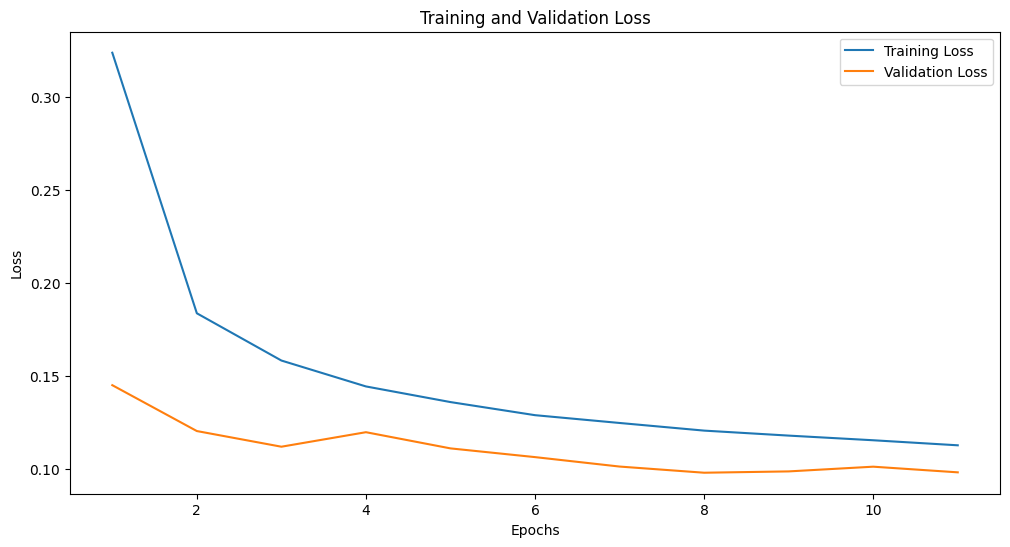

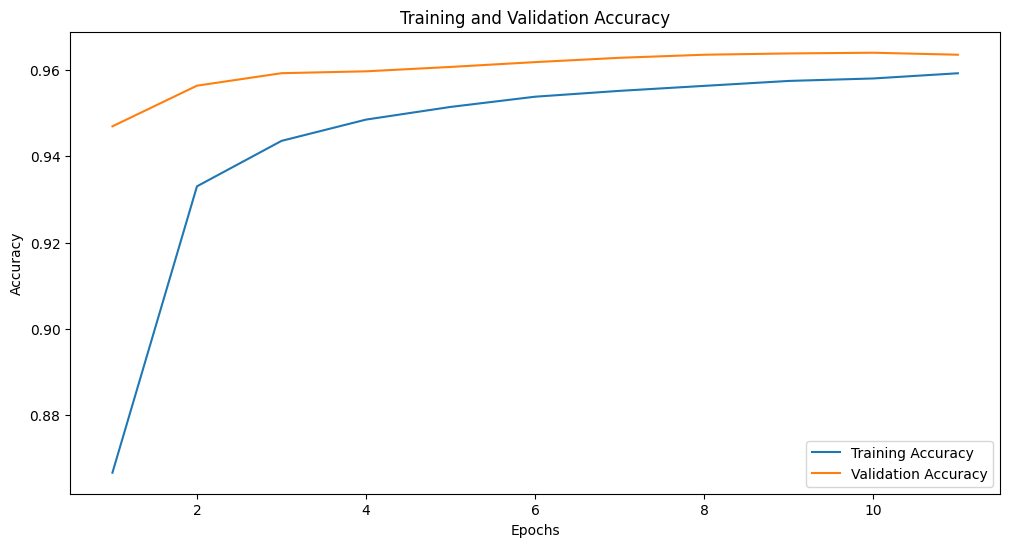

In [ ]:
# metrics from history
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

# training/ validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, history_dict['loss'], label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# training/ validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, history_dict['binary_accuracy'], label='Training Accuracy')
plt.plot(epochs, history_dict['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


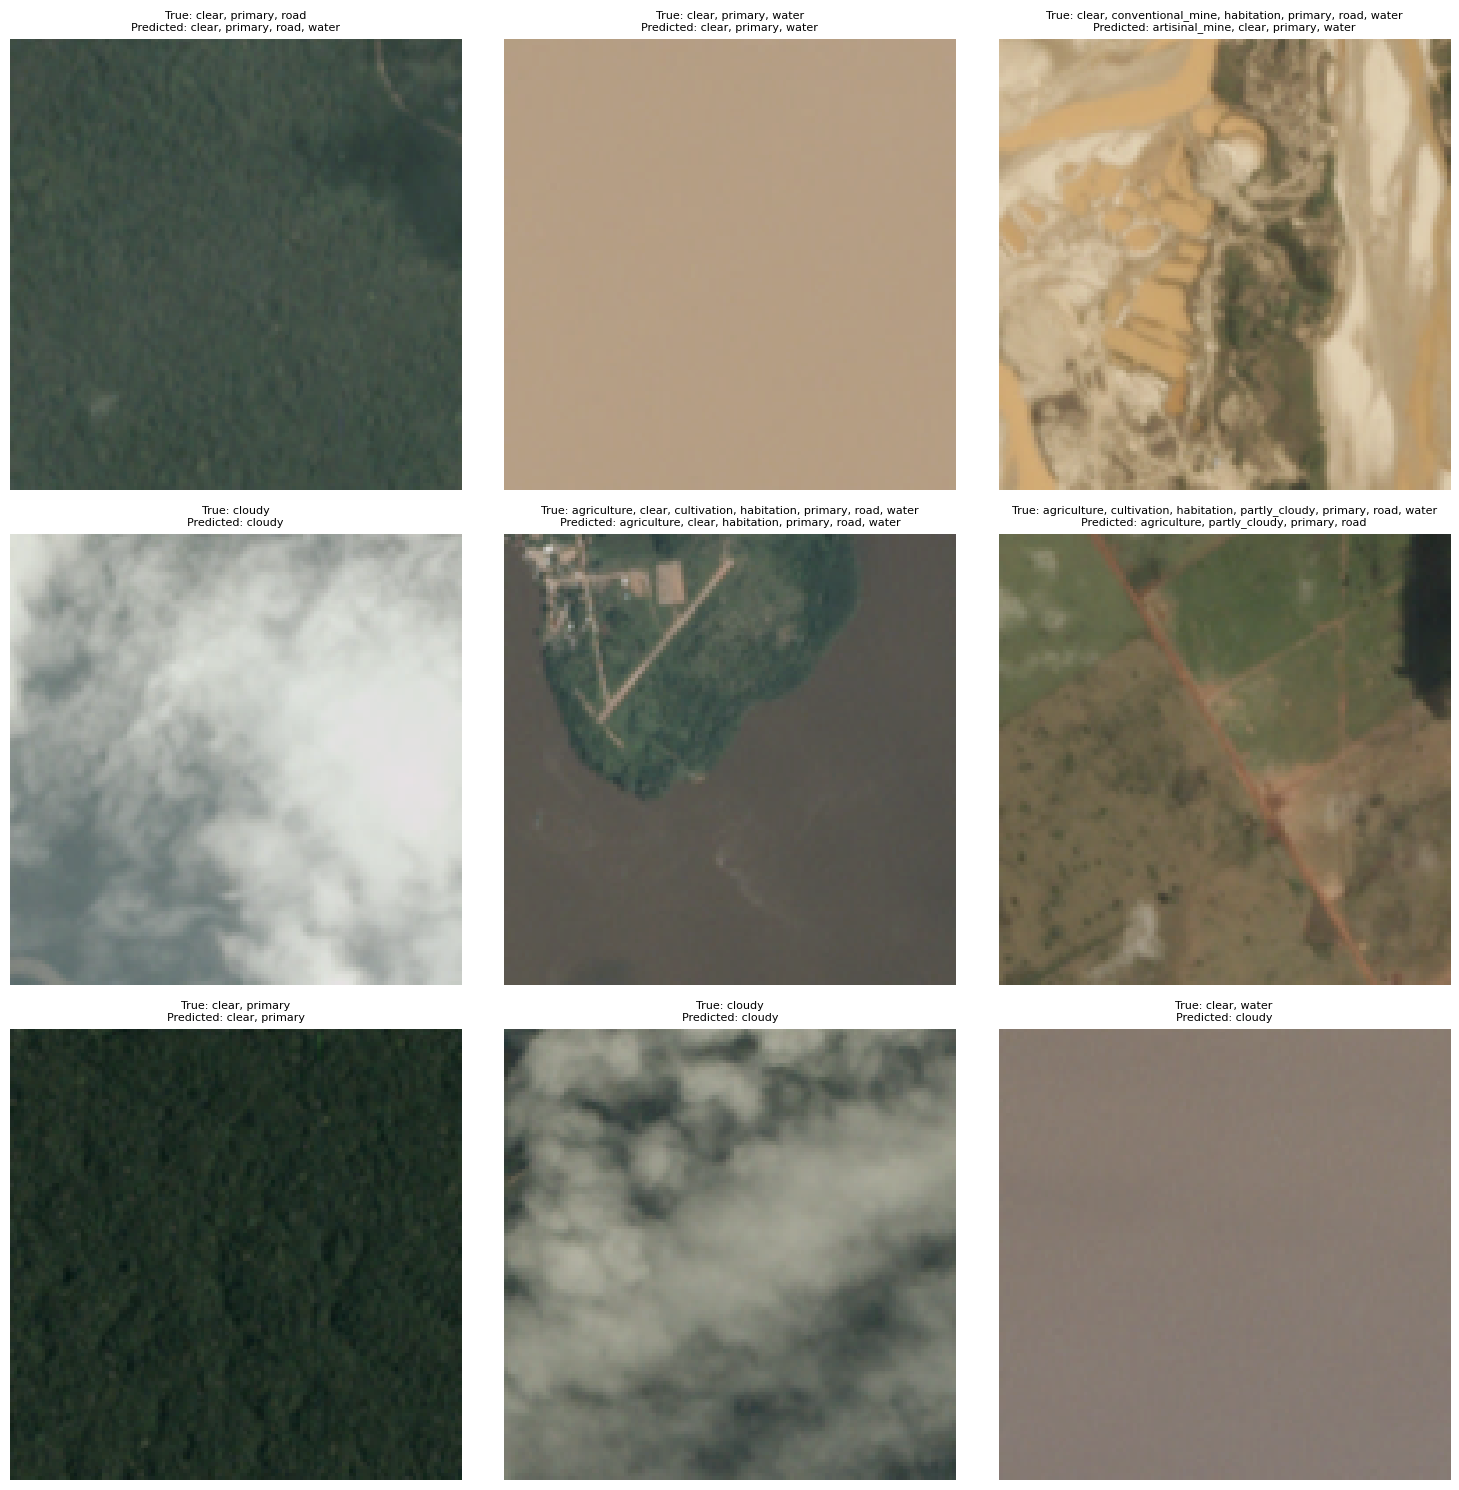

In [ ]:
#batch of validation data
for images, true_labels in val_dataset_numpy.take(1):
    predictions = model.predict(images)  # predict probabilities for the batch

    # turn into binary predictions
    predicted_labels = (predictions > 0.5).astype(int)

    # Plot images w/ predictions
    plt.figure(figsize=(15, 15))
    for i in range(9):  # first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy() + 1) / 2.0)  # Denormalize image to [0, 1]
        plt.axis('off')
        true_label_text = ", ".join([label for label, present in zip(labels_map.keys(), true_labels[i]) if present])
        predicted_label_text = ", ".join([label for label, present in zip(labels_map.keys(), predicted_labels[i]) if present])
        plt.title(f"True: {true_label_text}\nPredicted: {predicted_label_text}", fontsize=8)
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

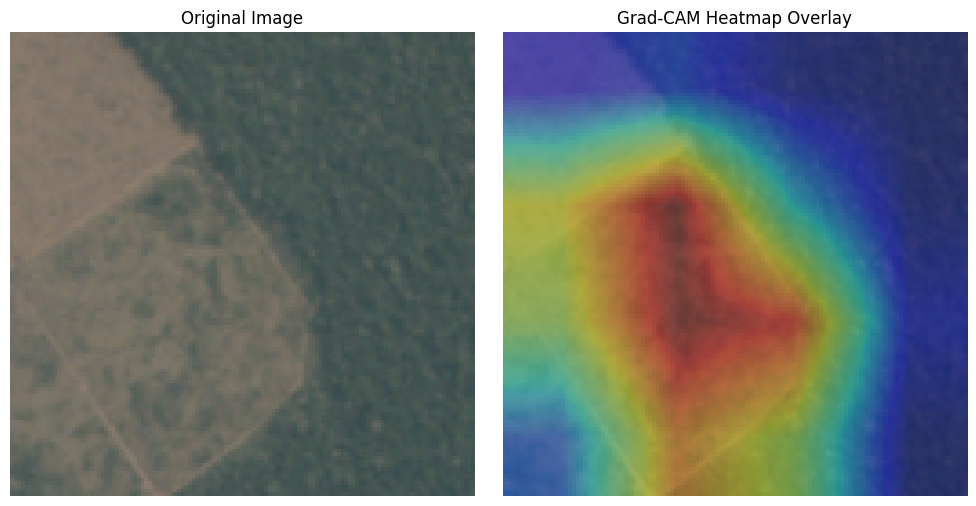

  Image 2: Confidence: 0.9978


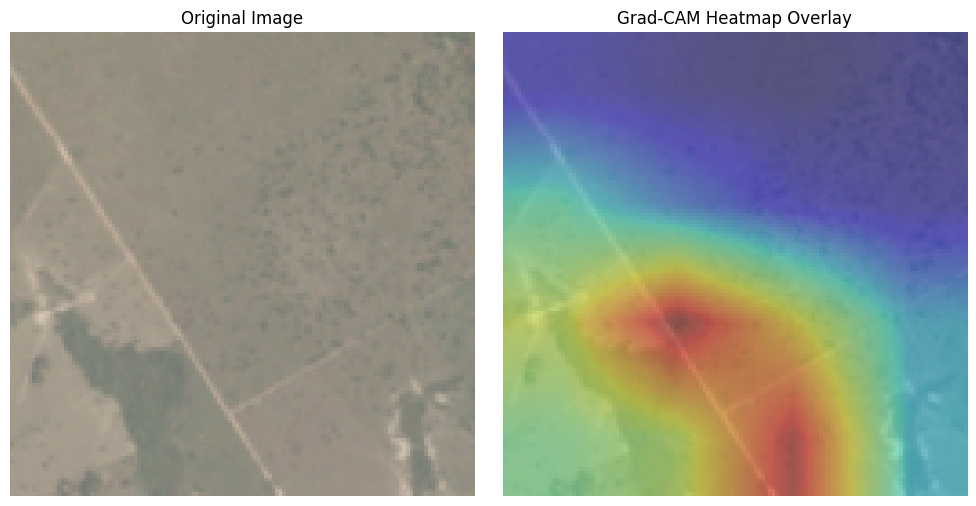

  Image 3: Confidence: 0.9978


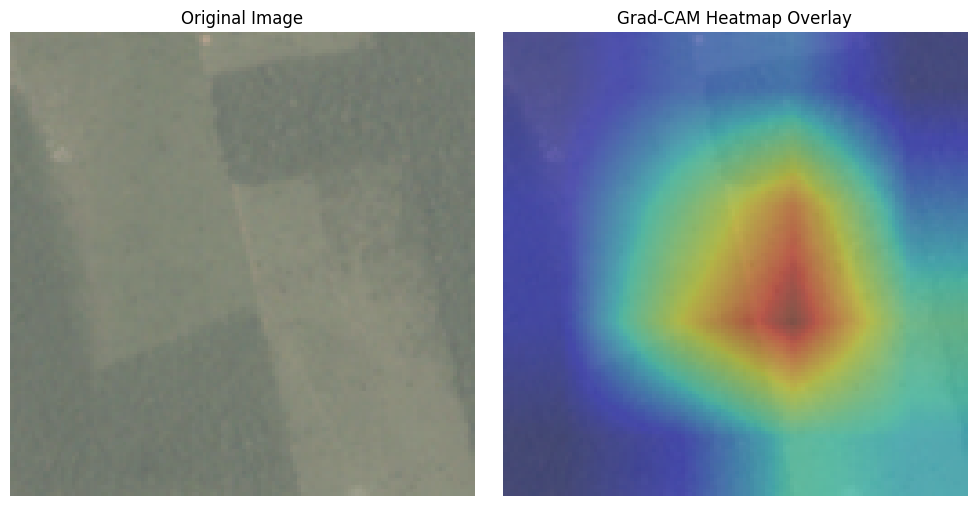

Class: artisinal_mine
  Image 1: Confidence: 0.9999


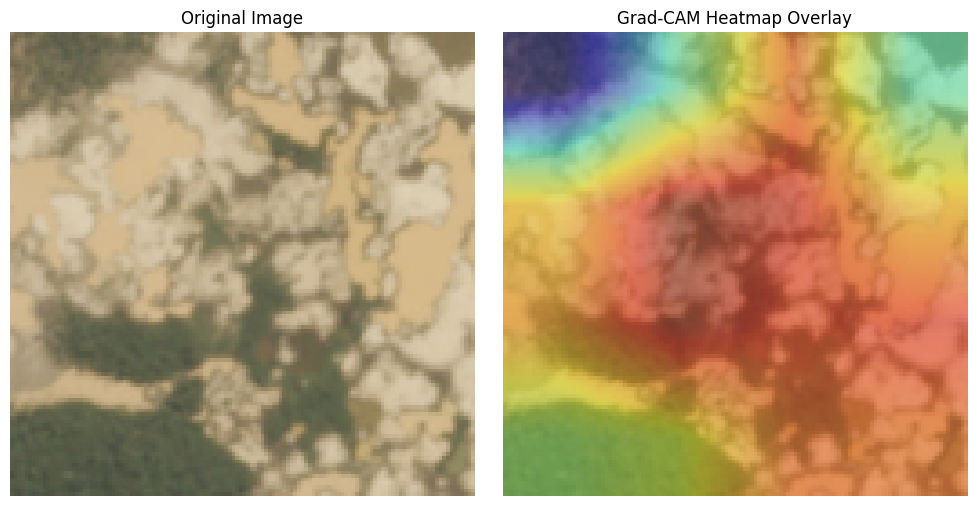

  Image 2: Confidence: 0.9998


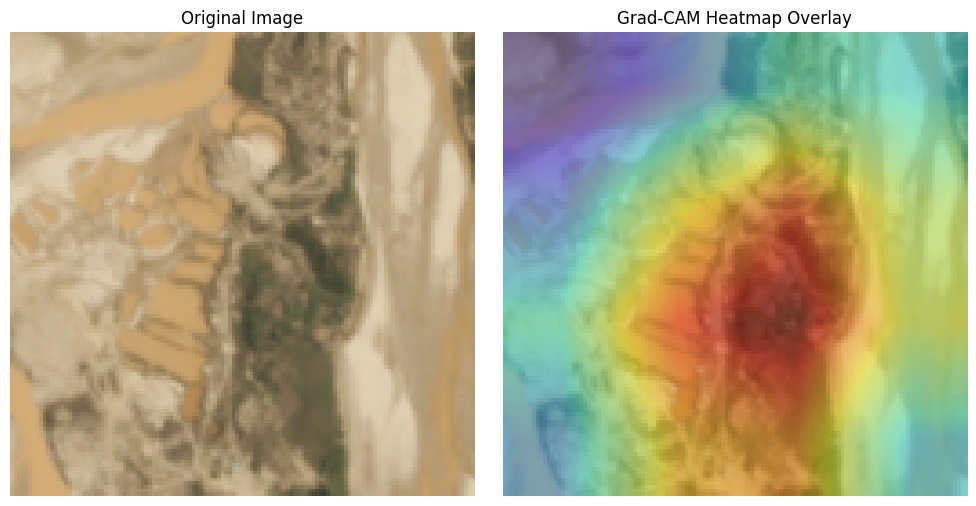

  Image 3: Confidence: 0.9997


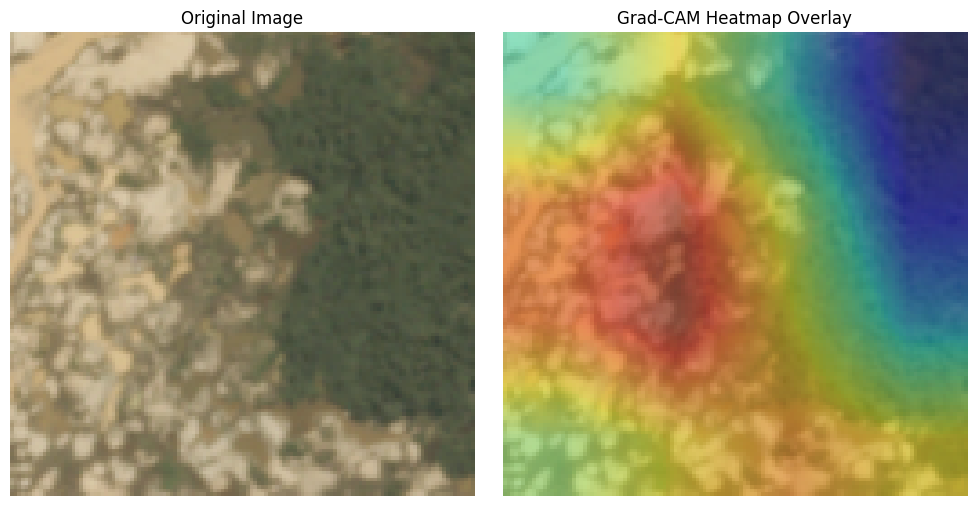

Class: bare_ground
  Image 1: Confidence: 0.7216


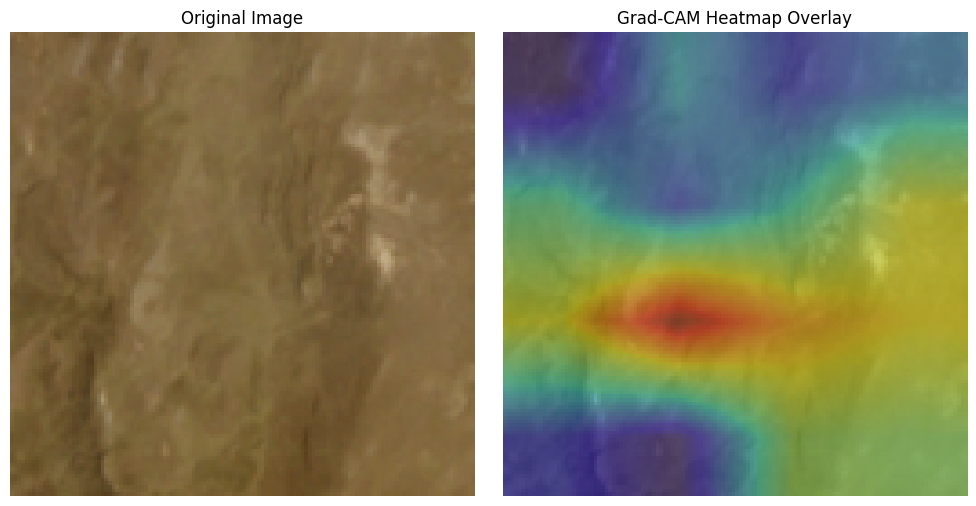

  Image 2: Confidence: 0.7191


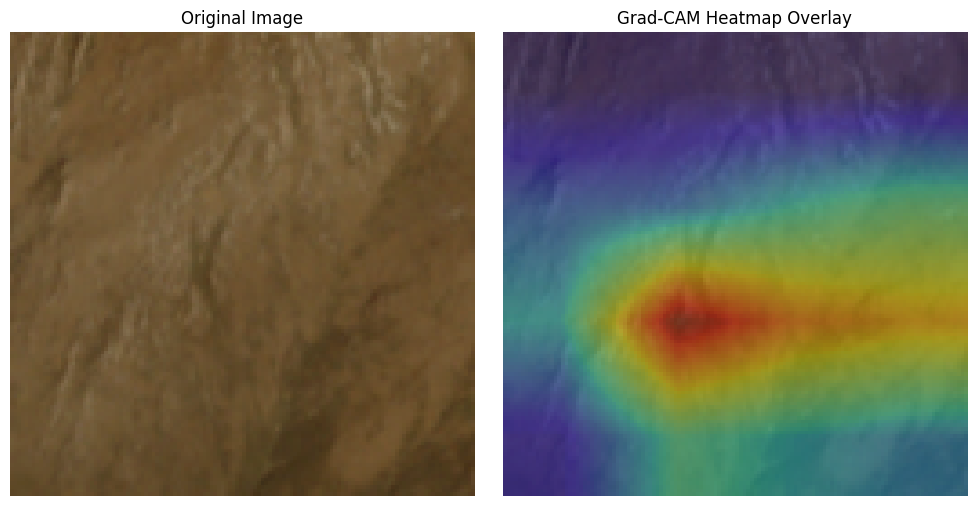

  Image 3: Confidence: 0.7173


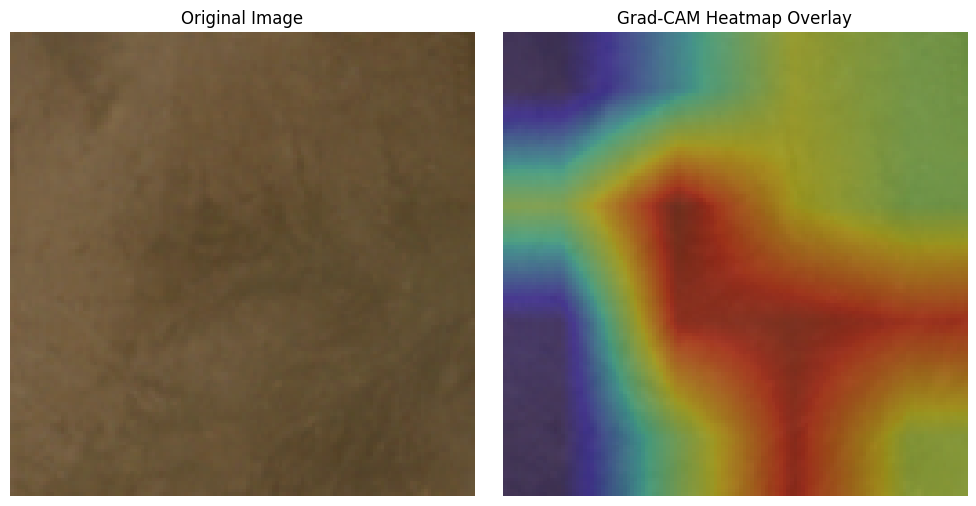

Class: blooming
  Image 1: Confidence: 0.5540


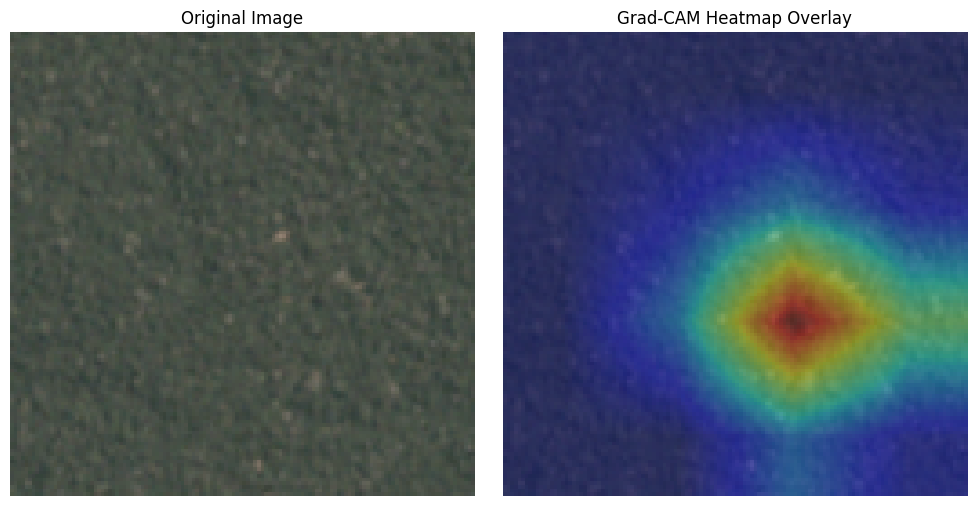

  Image 2: Confidence: 0.5301


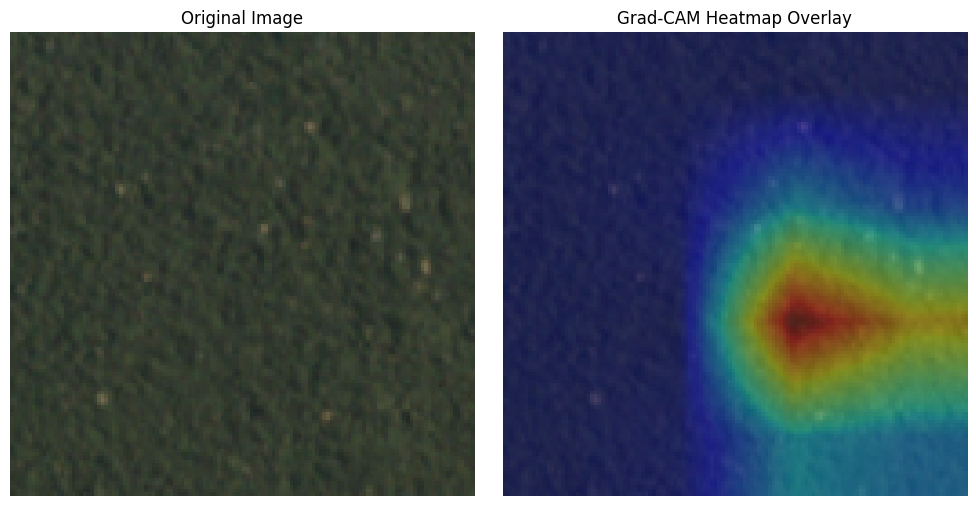

  Image 3: Confidence: 0.5269


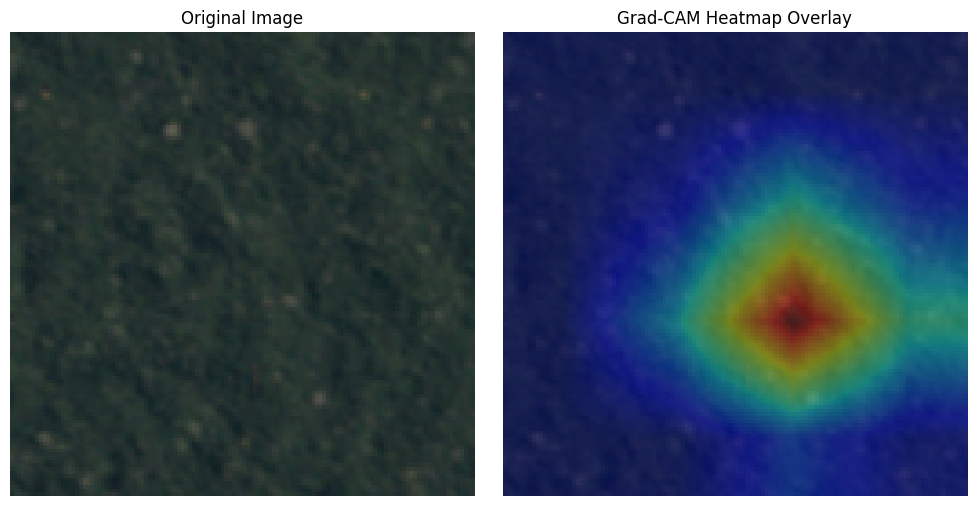

Class: blow_down
  Image 1: Confidence: 0.0444


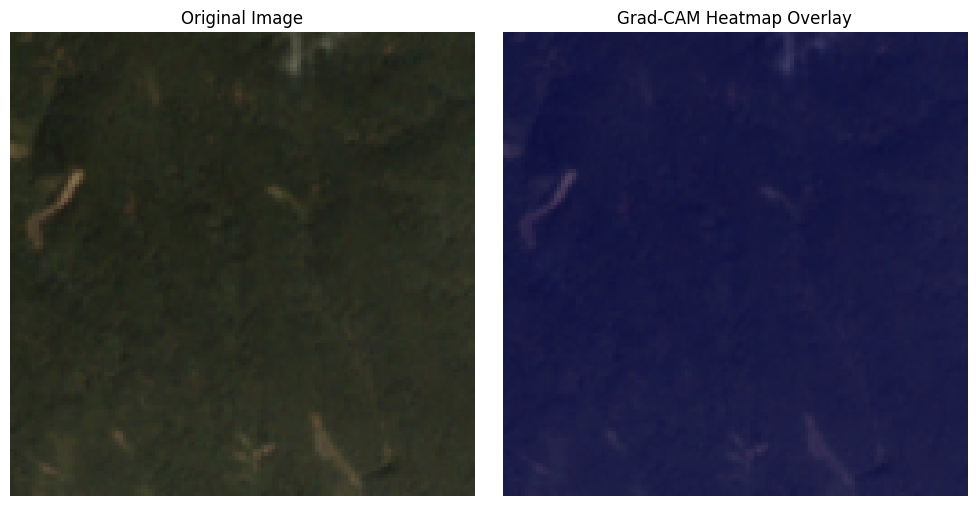

  Image 2: Confidence: 0.0434


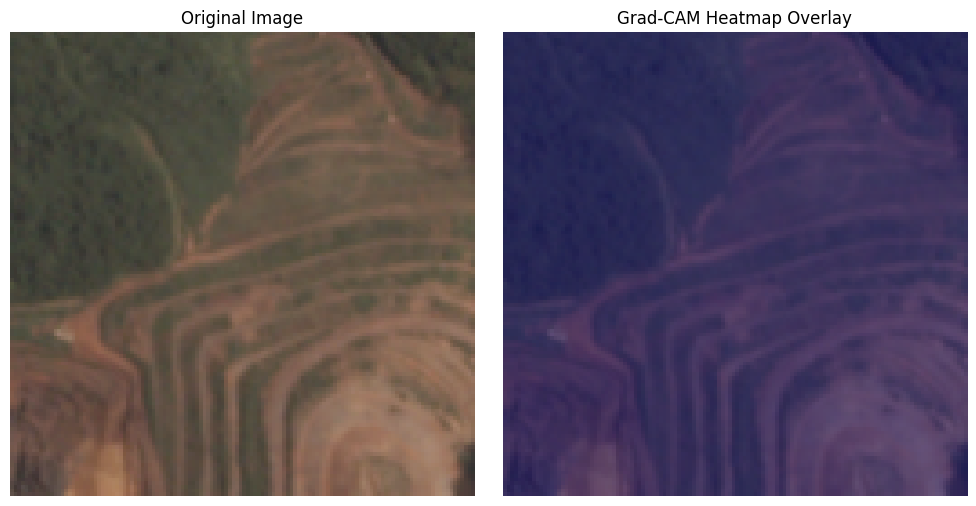

  Image 3: Confidence: 0.0409


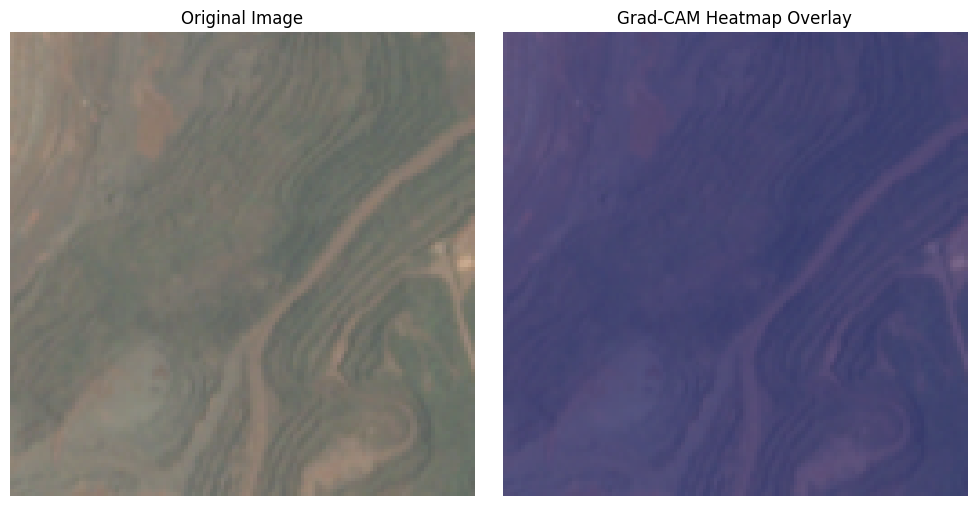

Class: clear
  Image 1: Confidence: 1.0000


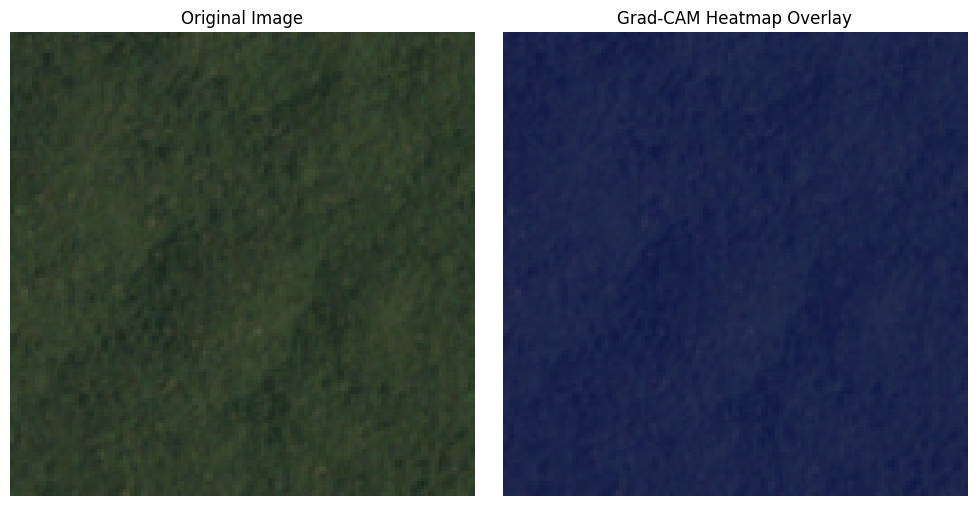

  Image 2: Confidence: 1.0000


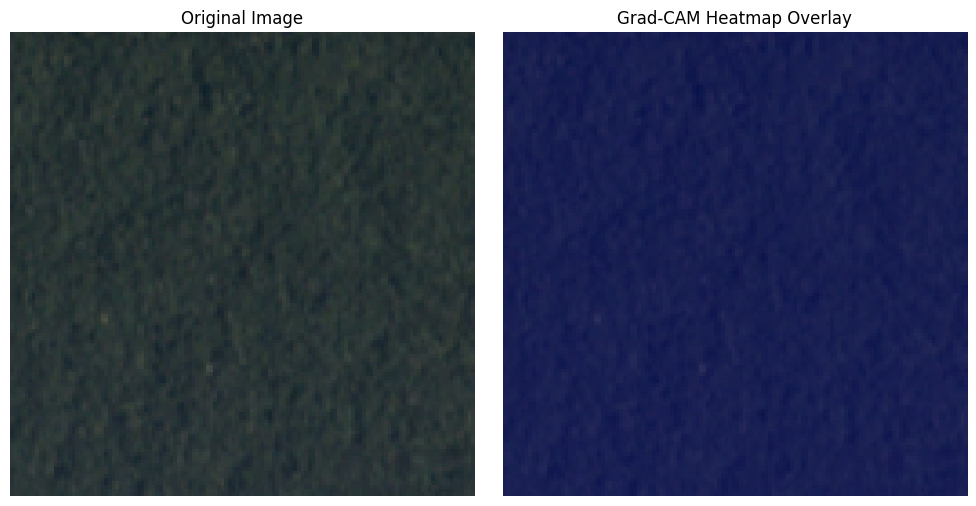

  Image 3: Confidence: 1.0000


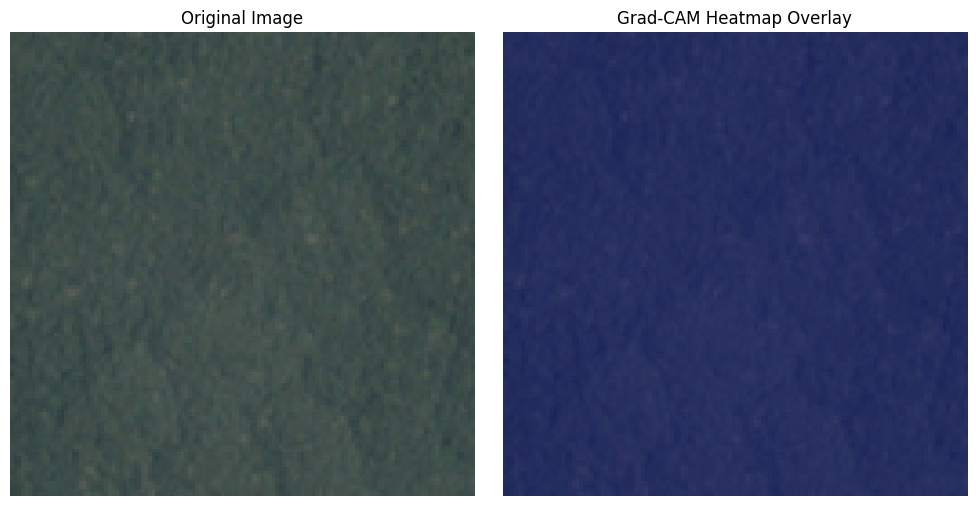

Class: cloudy
  Image 1: Confidence: 1.0000


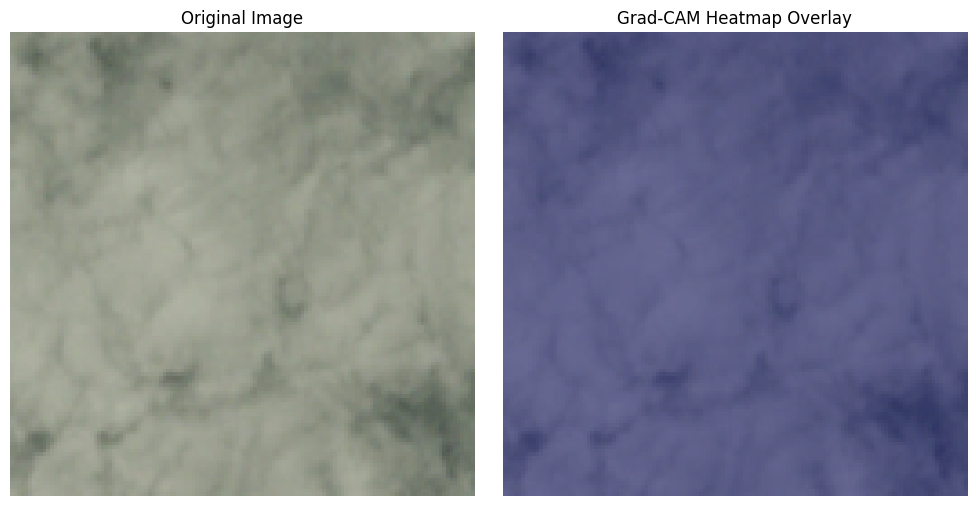

  Image 2: Confidence: 1.0000


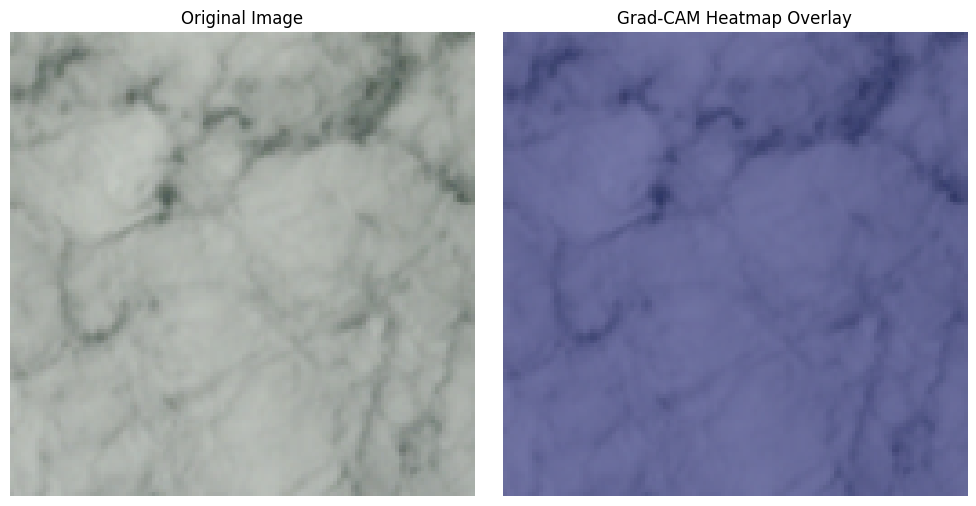

  Image 3: Confidence: 1.0000


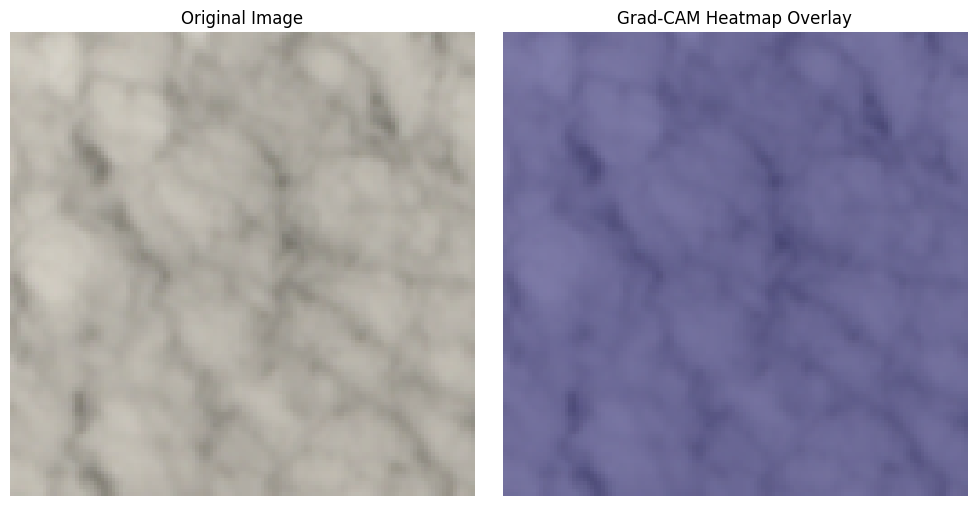

Class: conventional_mine
  Image 1: Confidence: 0.1183


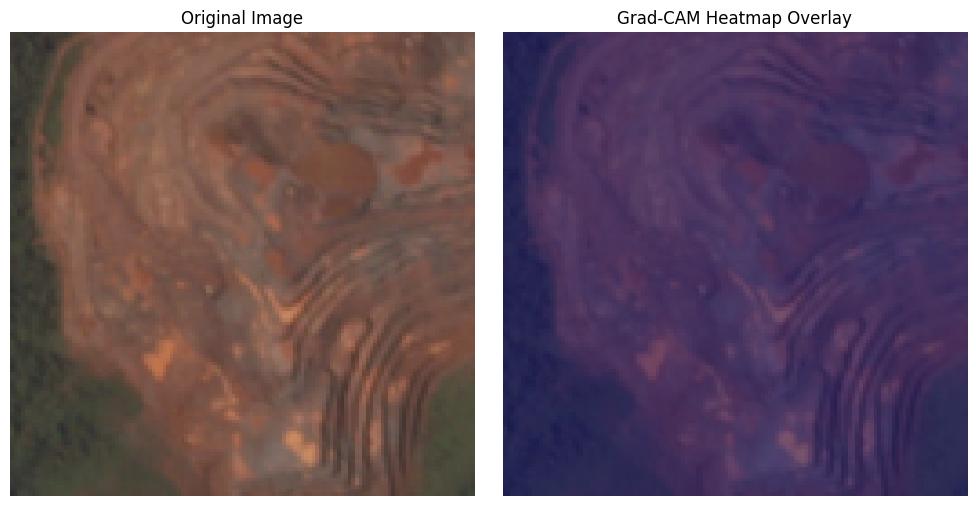

  Image 2: Confidence: 0.0933


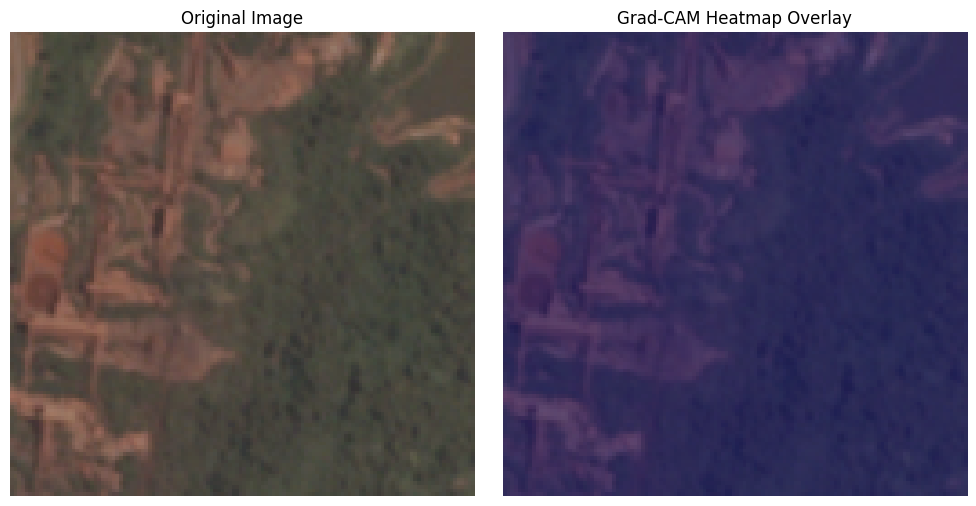

  Image 3: Confidence: 0.0840


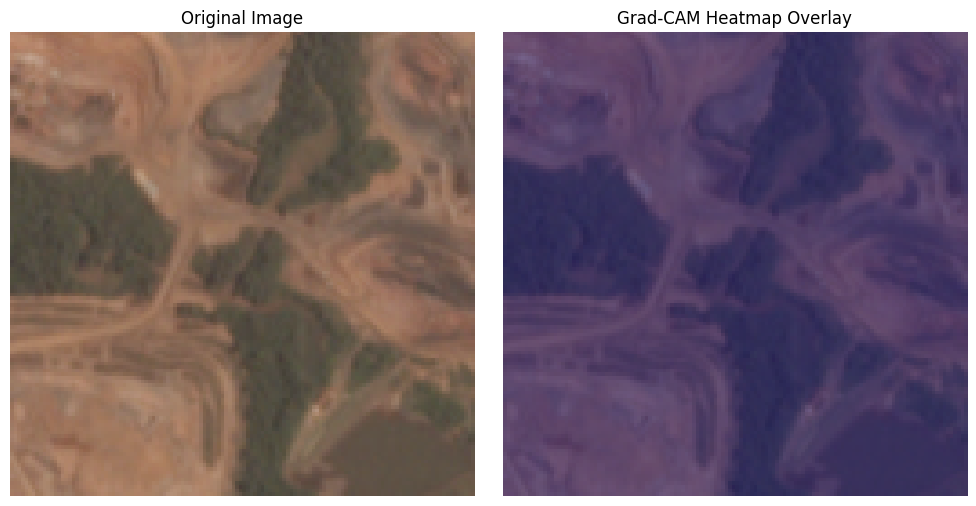

Class: cultivation
  Image 1: Confidence: 0.9854


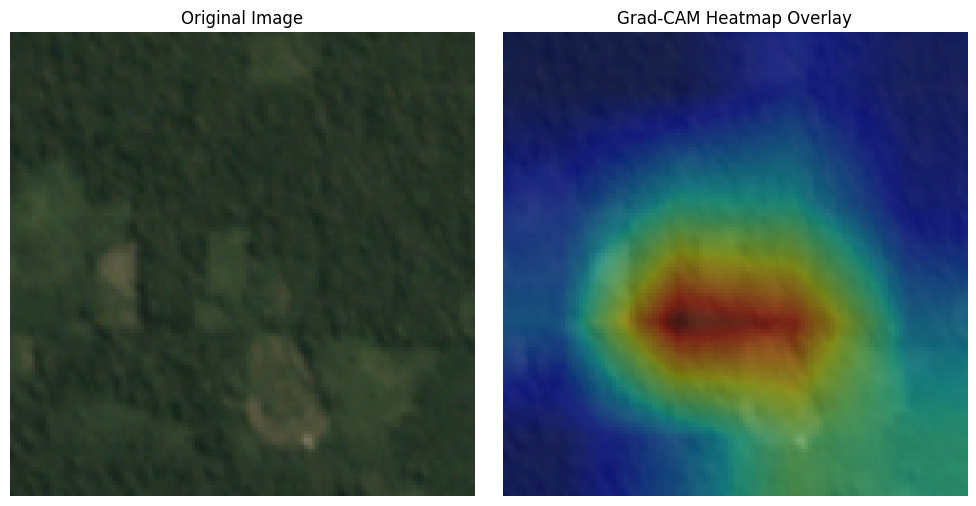

  Image 2: Confidence: 0.9822


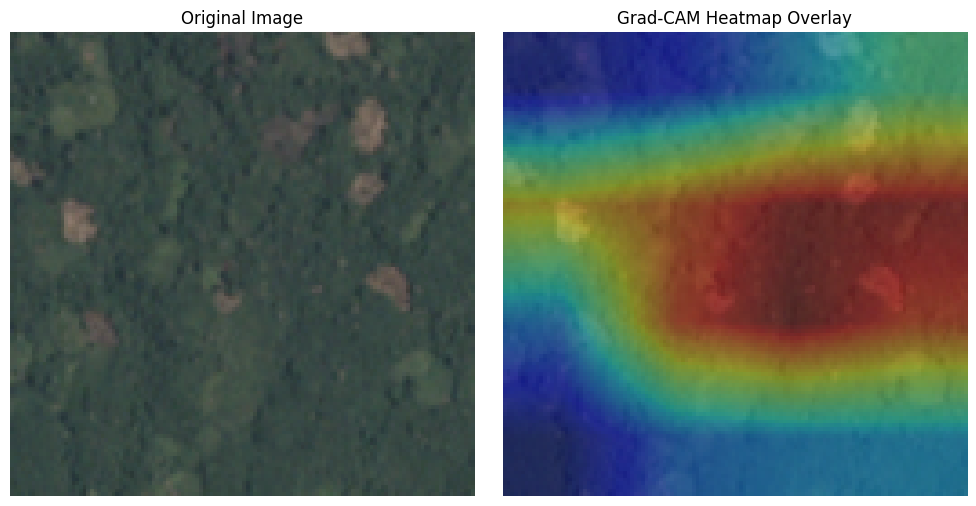

  Image 3: Confidence: 0.9780


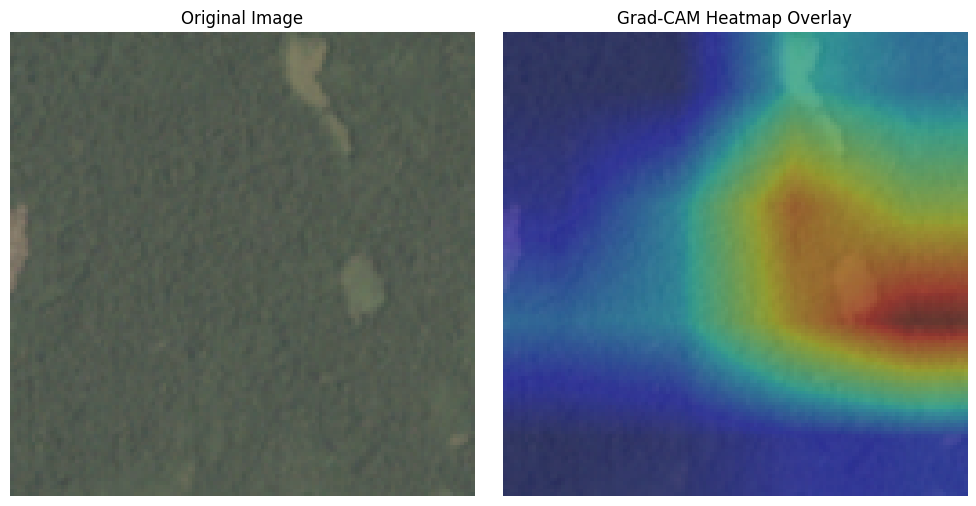

Class: habitation
  Image 1: Confidence: 0.9995


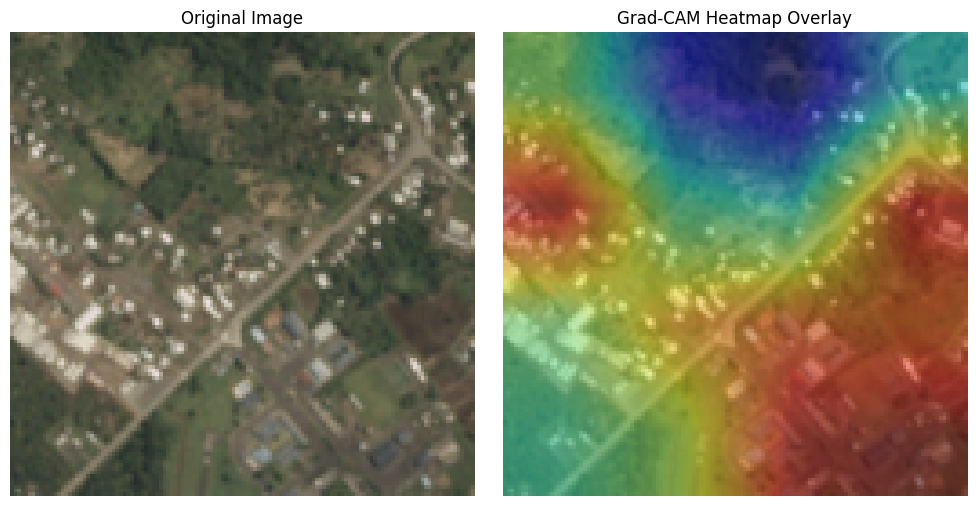

  Image 2: Confidence: 0.9987


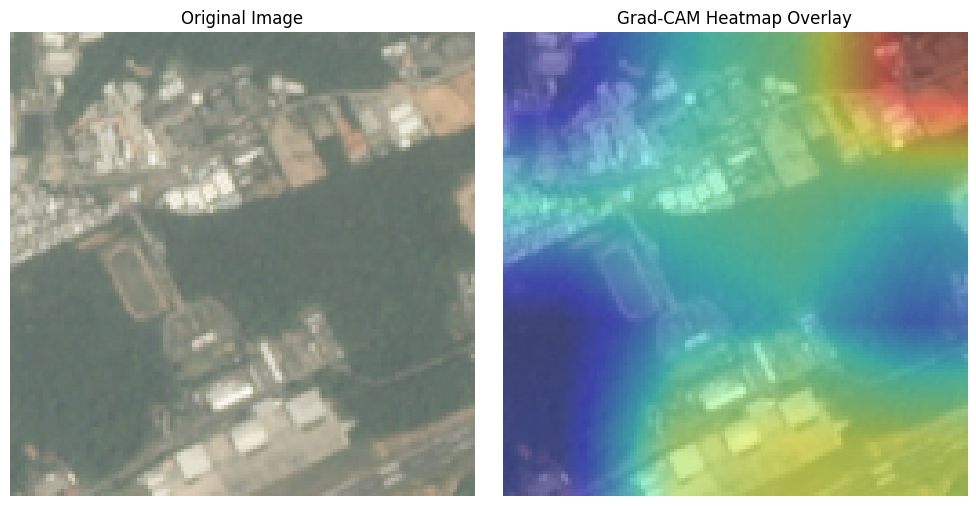

  Image 3: Confidence: 0.9983


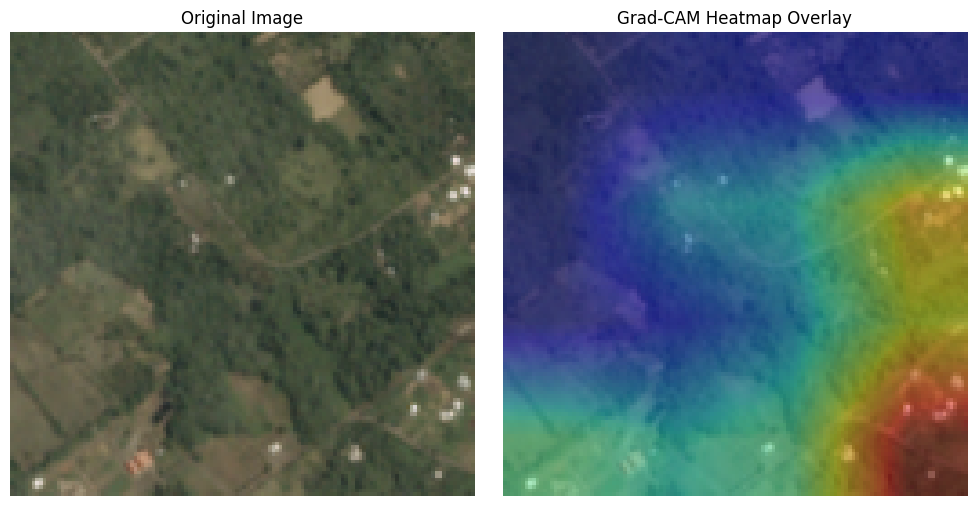

Class: haze
  Image 1: Confidence: 0.9926


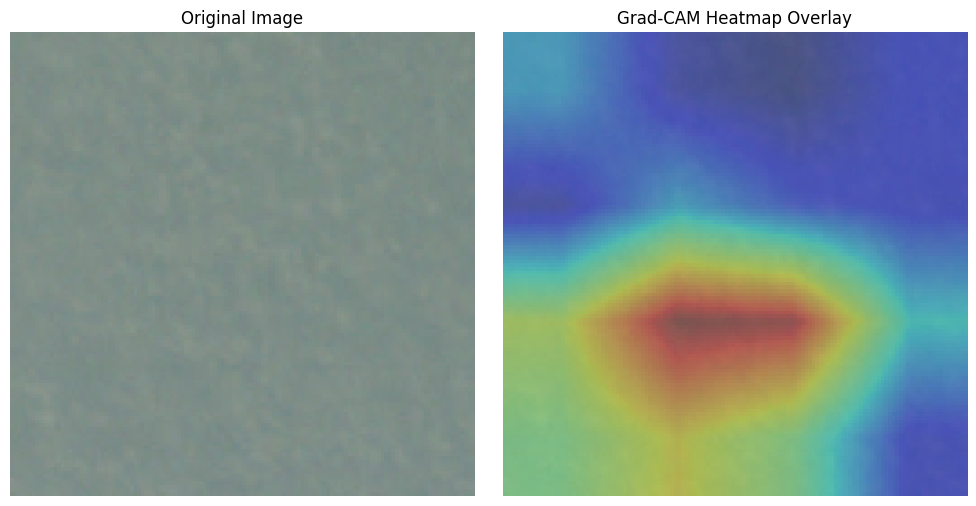

  Image 2: Confidence: 0.9862


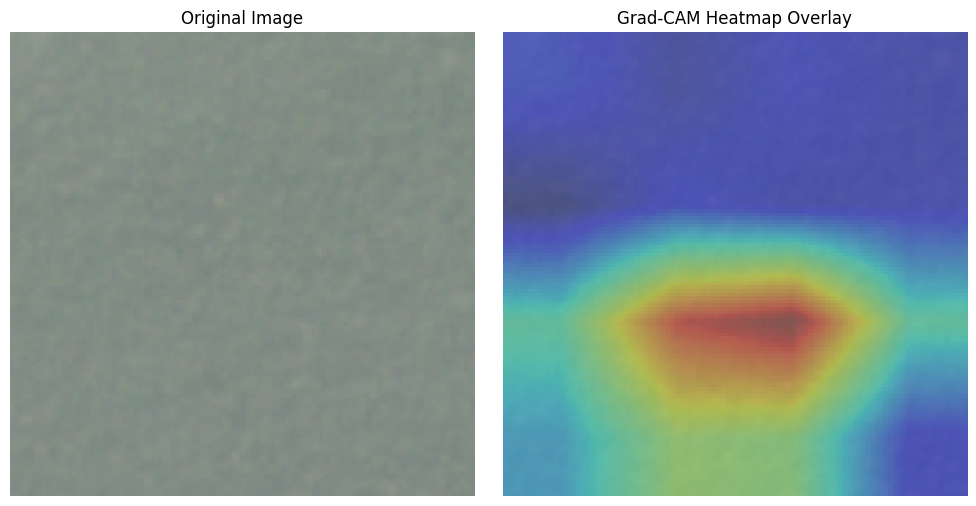

  Image 3: Confidence: 0.9855


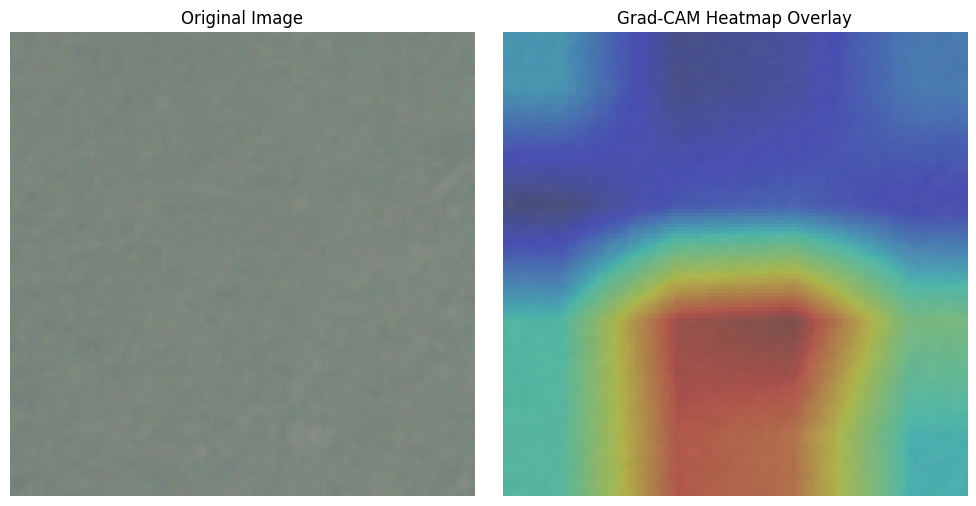

Class: partly_cloudy
  Image 1: Confidence: 1.0000


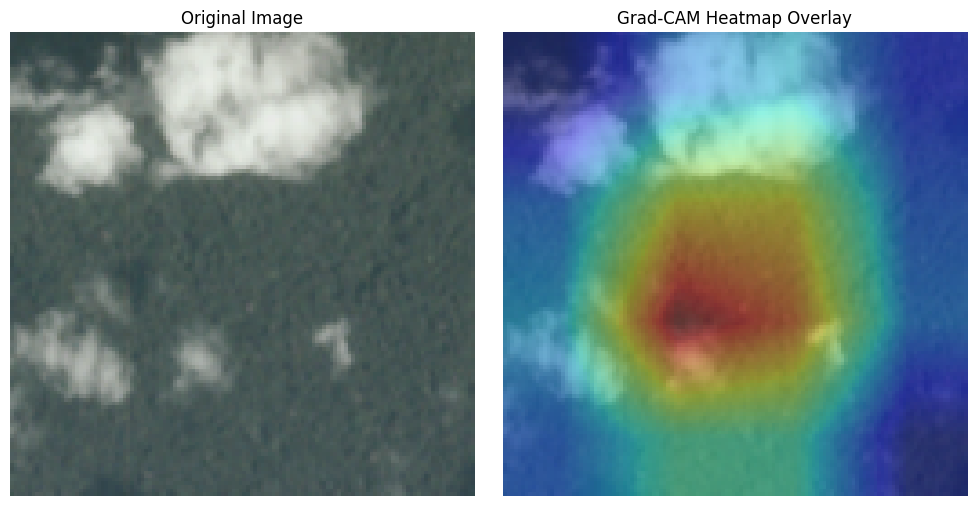

  Image 2: Confidence: 1.0000


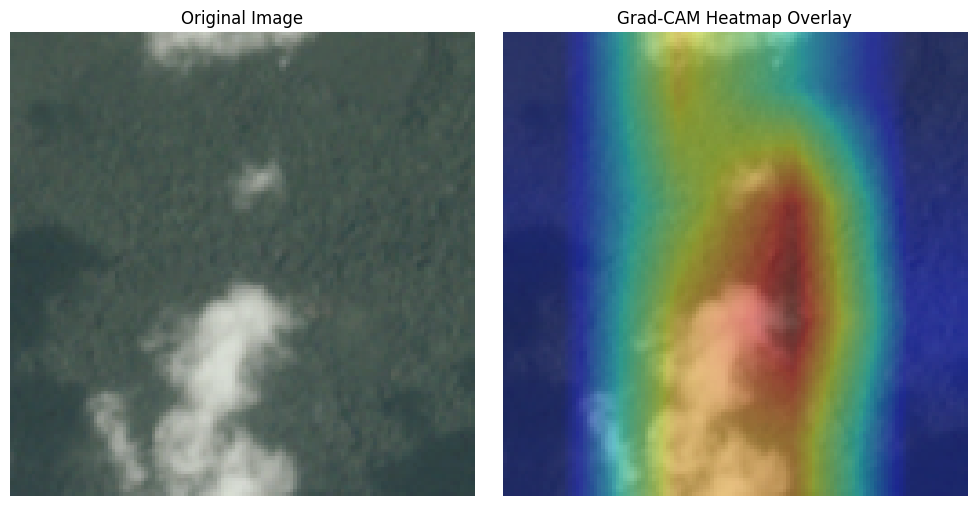

  Image 3: Confidence: 1.0000


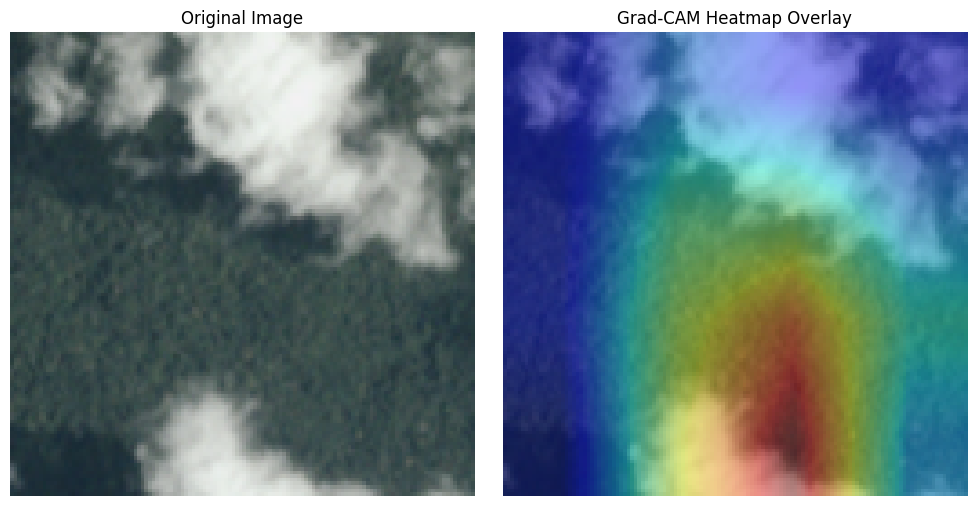

Class: primary
  Image 1: Confidence: 1.0000


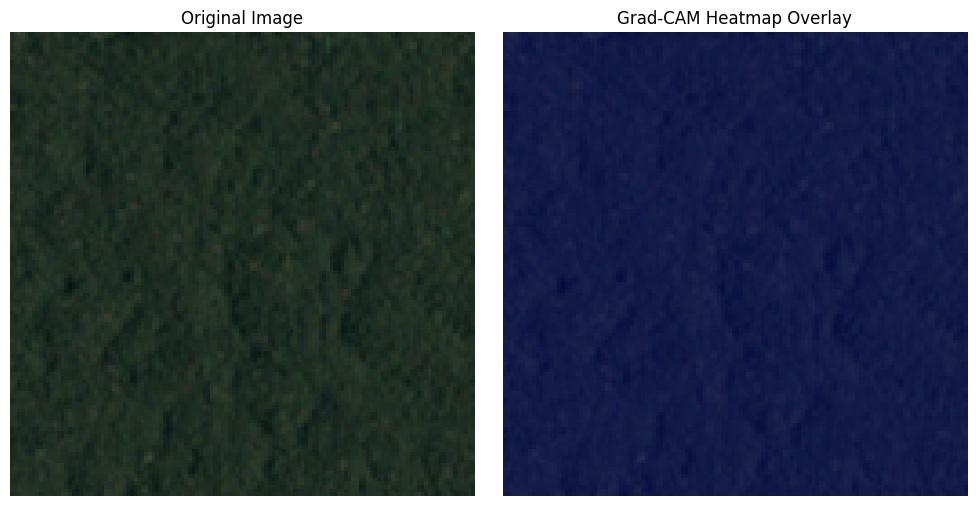

  Image 2: Confidence: 1.0000


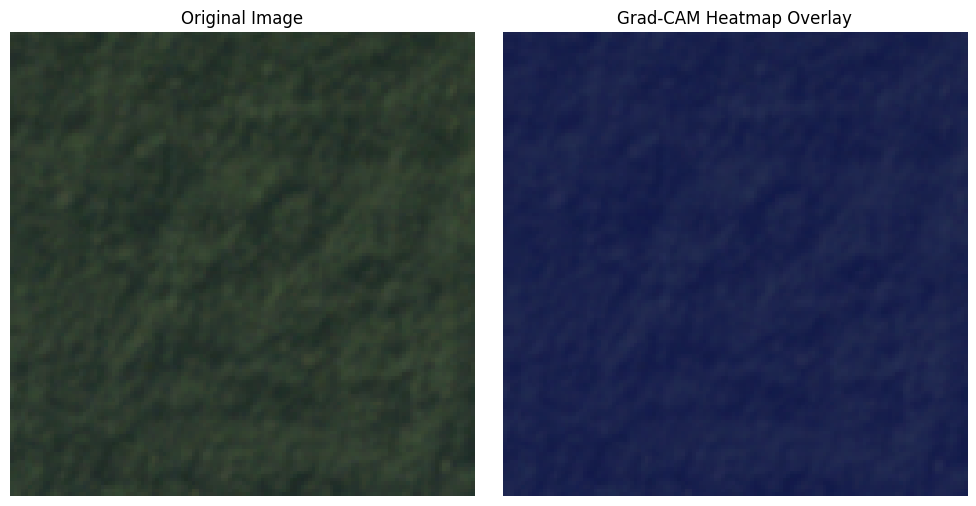

  Image 3: Confidence: 1.0000


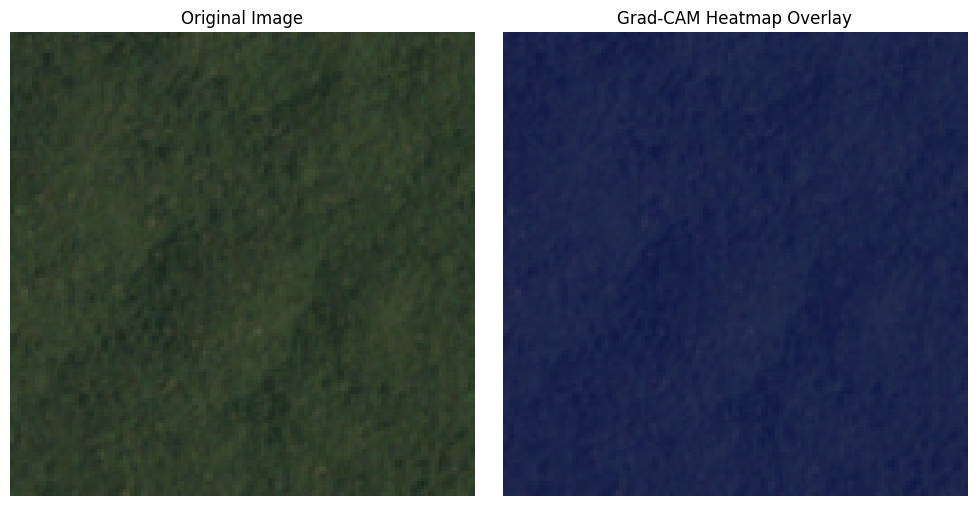

Class: road
  Image 1: Confidence: 0.9993


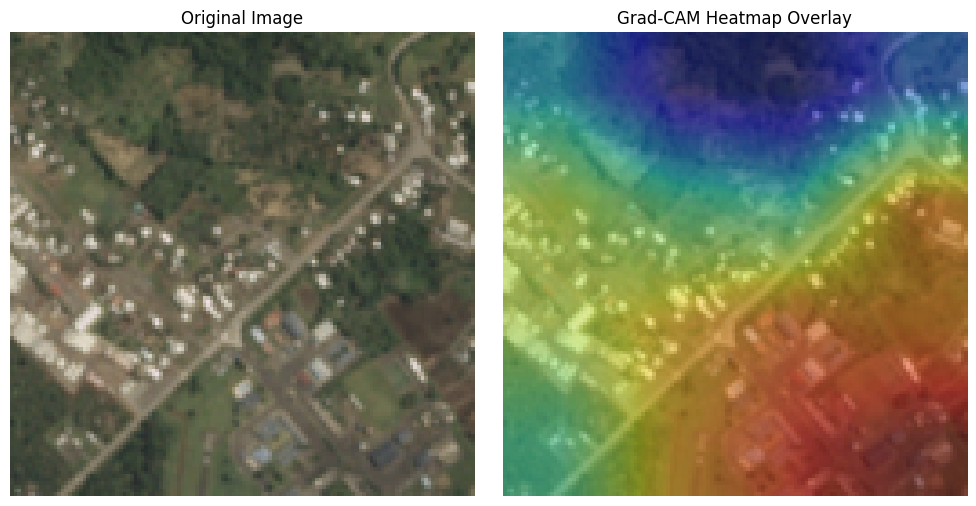

  Image 2: Confidence: 0.9990


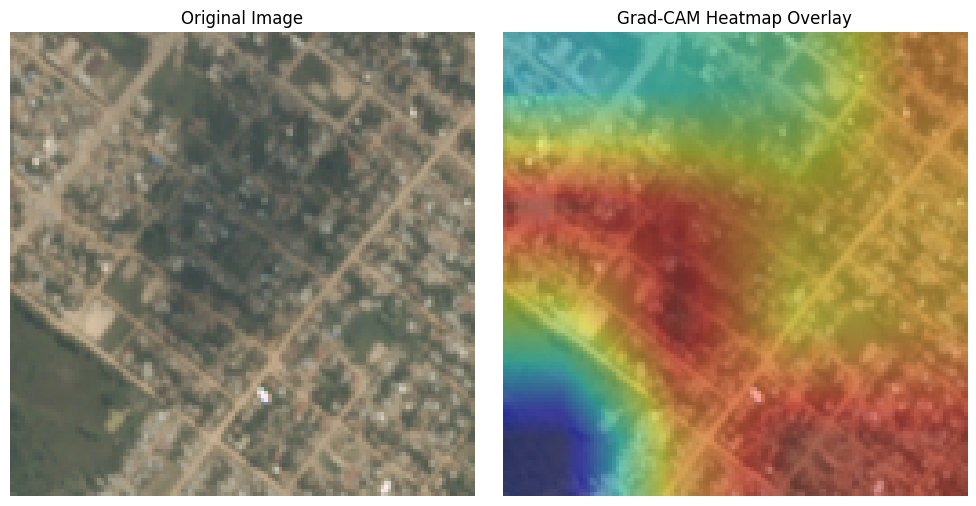

  Image 3: Confidence: 0.9989


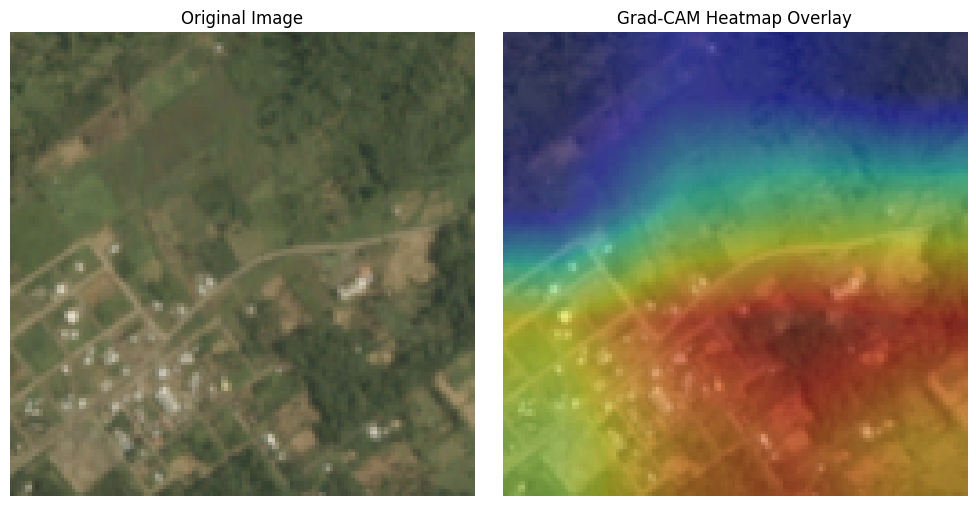

Class: selective_logging
  Image 1: Confidence: 0.8142


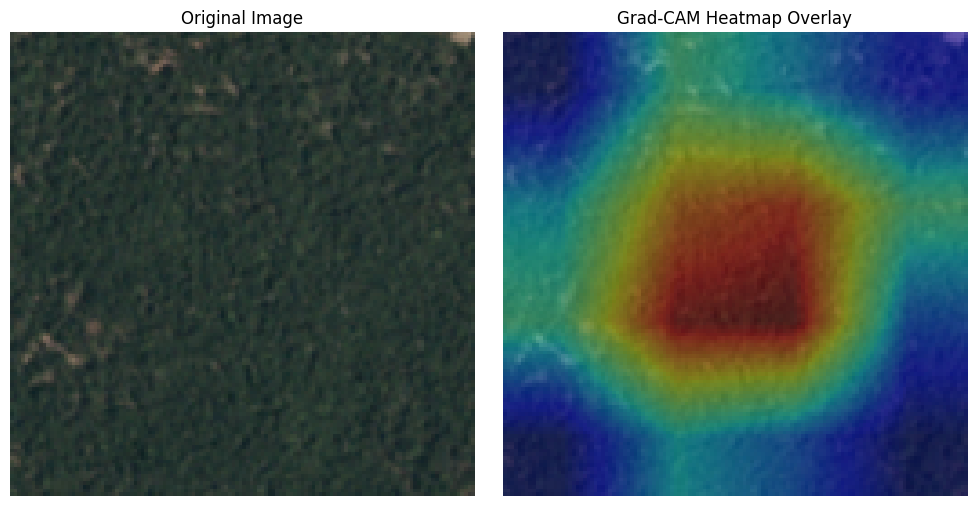

  Image 2: Confidence: 0.7303


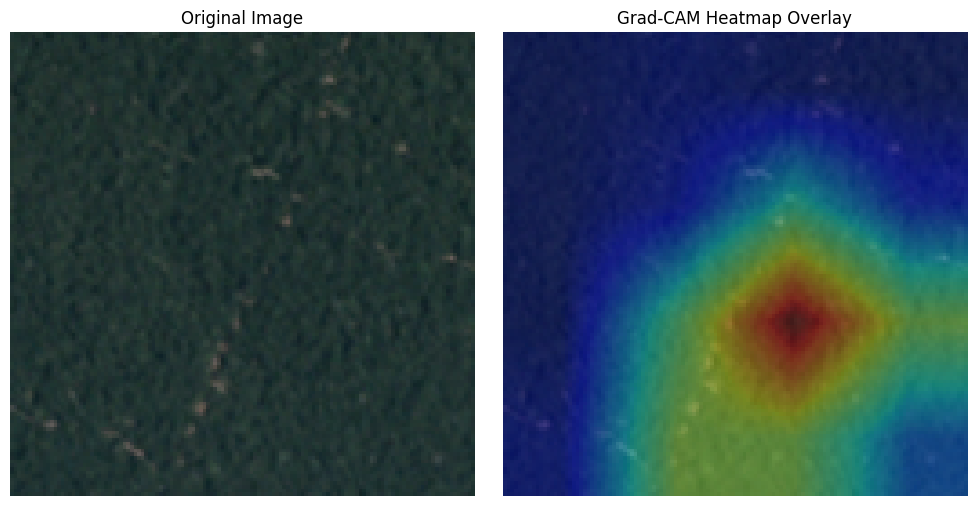

  Image 3: Confidence: 0.6946


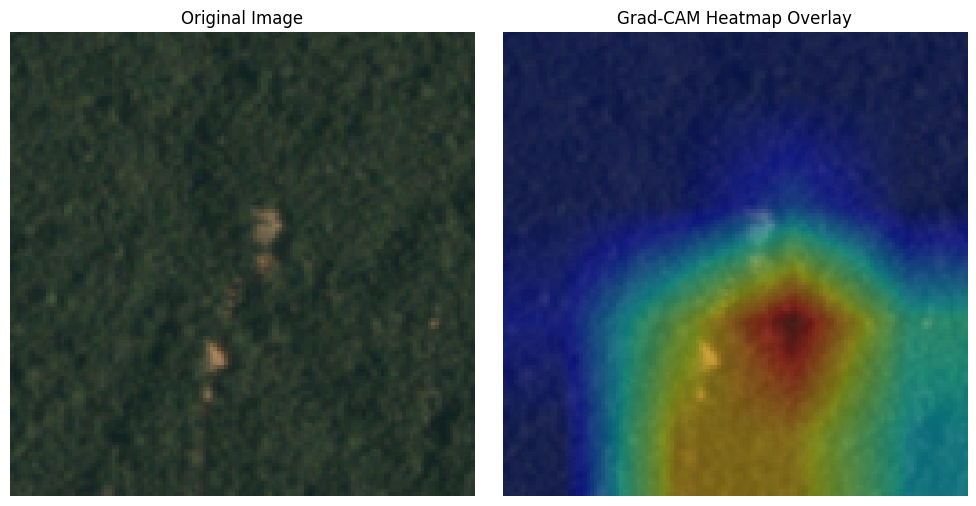

Class: slash_burn
  Image 1: Confidence: 0.1170


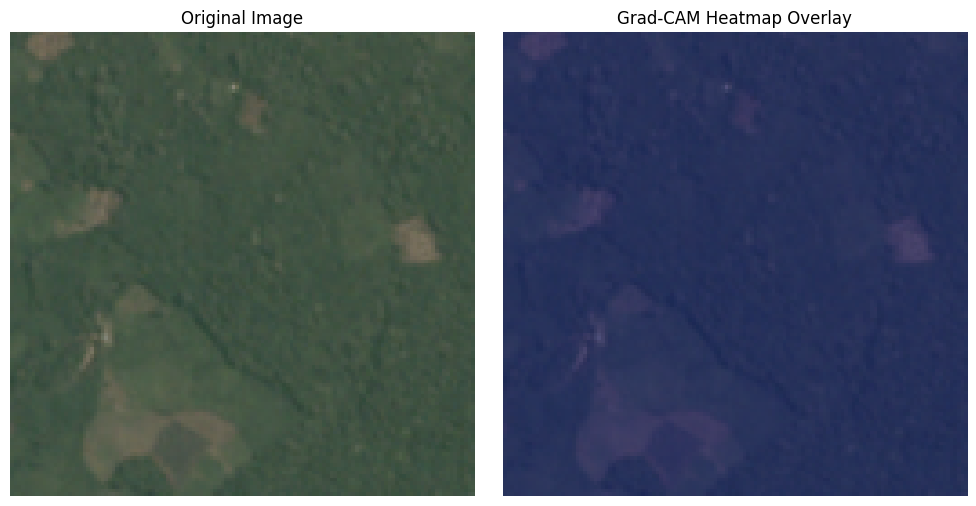

  Image 2: Confidence: 0.1105


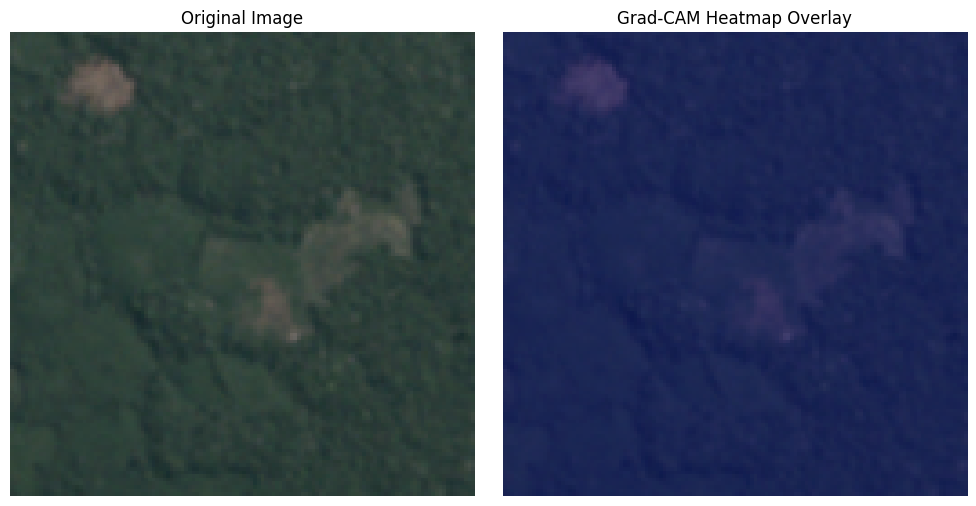

  Image 3: Confidence: 0.0899


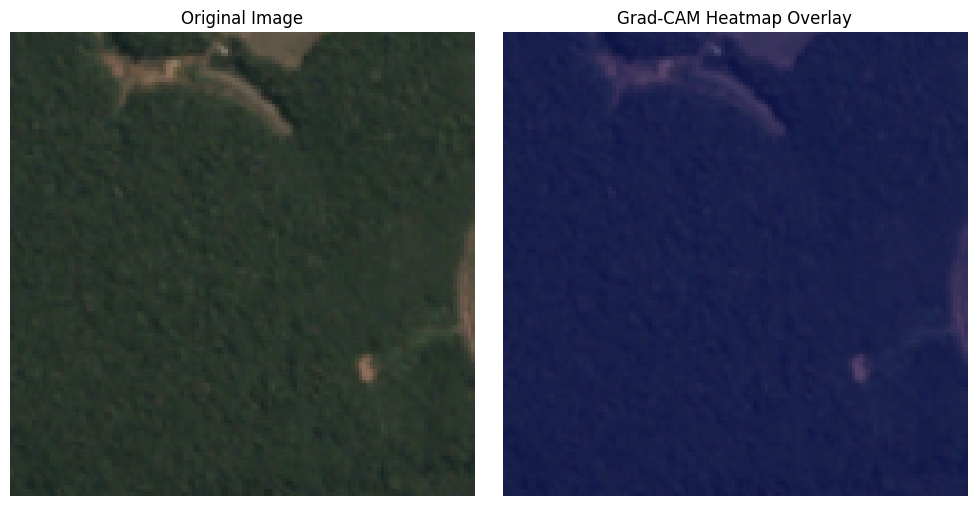

Class: water
  Image 1: Confidence: 1.0000


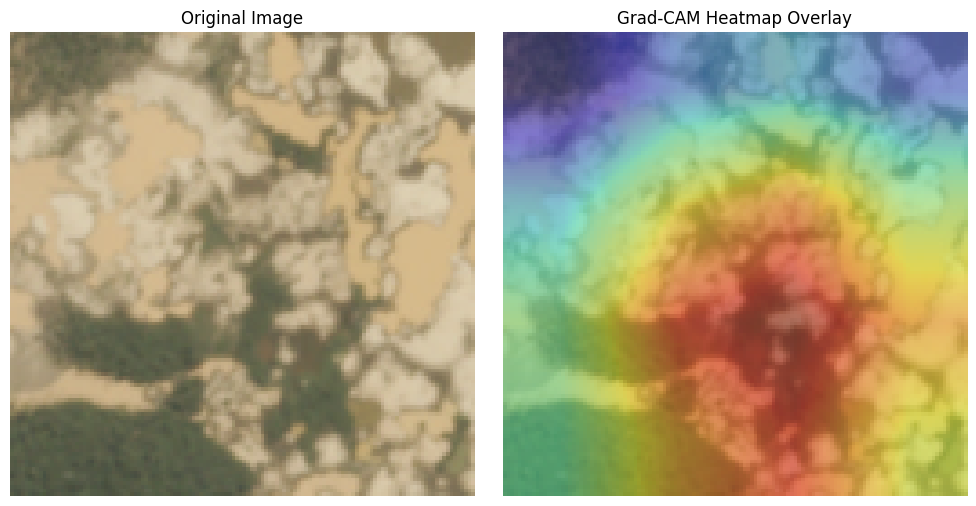

  Image 2: Confidence: 1.0000


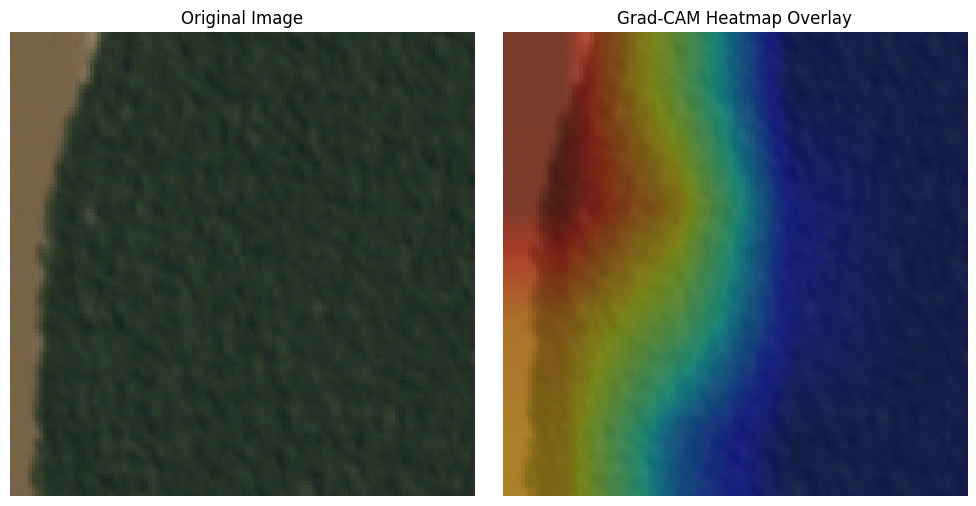

  Image 3: Confidence: 1.0000


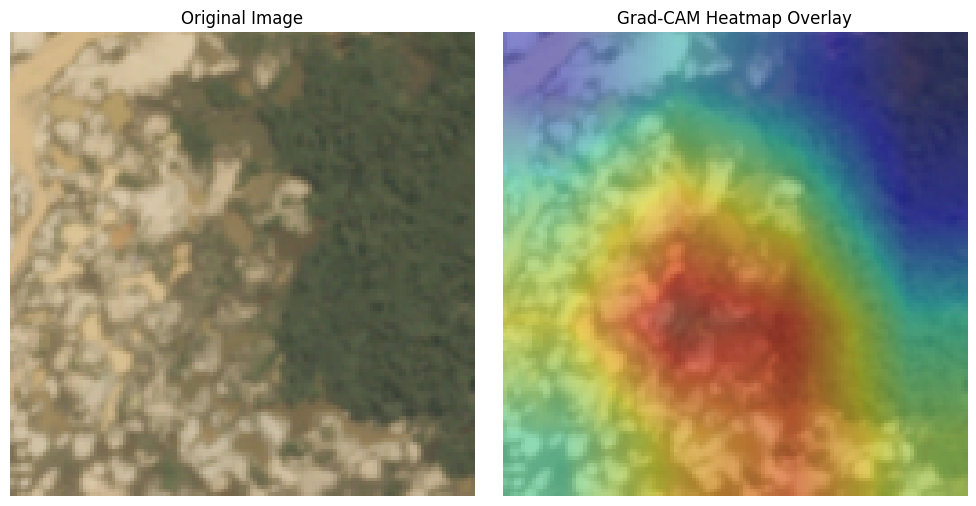

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, target_class):
    # Get last convolutional layer and build Grad-CAM
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, target_class]  # for the the specific class

    # find gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs[0], axis=-1)

    # normalizing the heatmap (0 - 1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap + 1e-8)  # Add small term so no division by zero
    return heatmap


def display_gradcam_with_original(img_tensor, model, last_conv_layer_name, target_class):
    """
    Display the original image and Grad-CAM heatmap side-by-side.
    Args:
        img_tensor: The image tensor.
        model: Trained model.
        last_conv_layer_name: Name of the last convolutional layer.
        target_class: Target class index for Grad-CAM.
    """
    # Expand dimensions if img_tensor is rank 3 (single image)
    if len(img_tensor.shape) == 3:
        img_tensor = tf.expand_dims(img_tensor, axis=0)

    # Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name, target_class)

    # Resize heatmap (match image size)
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (img_tensor.shape[1], img_tensor.shape[2])).numpy().squeeze()

    # Denormalize original image
    original_img = (img_tensor[0].numpy() + 1) / 2.0  # Convert from [-1, 1] to [0, 1]

    # Plot OG and Grad-CAM images next to each other
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(original_img)
    axes[1].imshow(heatmap_resized, cmap='jet', alpha=0.4)  # heatmap overlay
    axes[1].set_title("Grad-CAM Heatmap Overlay")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


# Grad-CAM for top_n # of 'top confident images' by class
def find_top_confident_images(dataset, model, labels_map, top_n=3):
    """
    Find the top N most confident images for each target class.
    Args:
        dataset: TensorFlow dataset containing images and labels.
        model: Trained model.
        labels_map: Dictionary mapping class names to indices.
        top_n: Number of top confident images to select for each class.
    Returns:
        A dictionary with class names as keys and lists of (image, score) tuples as values.
    """
    most_confident = {label: [] for label in labels_map.keys()}  # Initialize with empty lists

    for images, _ in dataset:
        predictions = model.predict(images)
        for i, img in enumerate(images):
            for class_name, class_idx in labels_map.items():
                confidence = predictions[i][class_idx]
                most_confident[class_name].append((img, confidence))

    # find/keep top N confident images for each class
    for class_name in most_confident.keys():
        most_confident[class_name] = sorted(
            most_confident[class_name], key=lambda x: x[1], reverse=True
        )[:top_n]

    return most_confident


def display_gradcam_for_top_images_with_original(most_confident_images, model, last_conv_layer_name):
    """
    Display Grad-CAM with original images for the top confident images for each target class.
    Args:
        most_confident_images: Dictionary with class names as keys and lists of (image, score) tuples as values.
        model: Trained model.
        last_conv_layer_name: Name of the last convolutional layer.
    """
    for class_name, image_data in most_confident_images.items():
        print(f"Class: {class_name}")
        for idx, (img_tensor, confidence) in enumerate(image_data):
            print(f"  Image {idx + 1}: Confidence: {confidence:.4f}")
            target_class = labels_map[class_name]

            # show OG and Grad-CAM heatmap next to each other
            display_gradcam_with_original(
                img_tensor,
                model,
                last_conv_layer_name=last_conv_layer_name,
                target_class=target_class
            )


# Find top_n # of most confident images by class
top_confident_images = find_top_confident_images(val_dataset_numpy, model, labels_map, top_n=3)

# show original images next to Grad-CAM-overlayed images
display_gradcam_for_top_images_with_original(
    top_confident_images,
    model,
    last_conv_layer_name='conv5_block3_out'  # specific layer (I chose last one)
)

In [ ]:
img_path = '/content/drive/MyDrive/satellite_imagery/train-jpg/train-jpg/train_1.jpg'
image_name = img_path.split('/')[-1].split('.')[0]

def get_ground_truth(image_name, labels_df, labels_map):
    # row in labels_df corresponding with image_name
    row = labels_df[labels_df['image_name'] == image_name]

    if row.empty:
        print(f"No ground truth found for image: {image_name}")
        return [0] * len(labels_map)  # Return all-zero one-hot encoding if not found

    # retrieve tags and encode
    tags = row['tags'].values[0].split()
    ground_truth = [1 if label in tags else 0 for label in labels_map.keys()]  # One-hot encode

    return ground_truth

ground_truth_labels = get_ground_truth(image_name, labels_df, labels_map)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


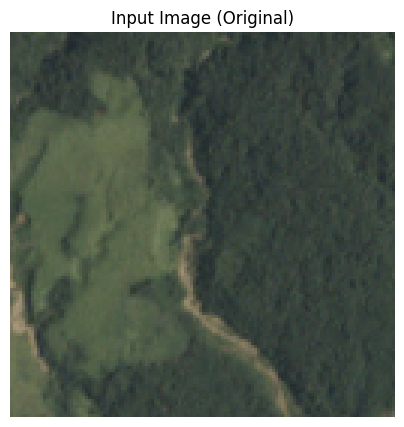

Predictions:
agriculture: 0.0000
artisinal_mine: 0.0000
bare_ground: 0.0000
blooming: 0.0000
blow_down: 0.0000
clear: 1.0000
cloudy: 0.0000
conventional_mine: 0.0000
cultivation: 0.0000
habitation: 0.0000
haze: 0.0000
partly_cloudy: 0.0000
primary: 1.0000
road: 0.0000
selective_logging: 0.0000
slash_burn: 0.0000
water: 1.0000

Ground Truth:
agriculture
clear
primary
water


In [ ]:
def show_image_and_predictions(img_path, model, class_labels, ground_truth_labels):
    import matplotlib.pyplot as plt

    # Load image
    img = tf.keras.utils.load_img(img_path, target_size=(128, 128))

    #image to NumPy array
    img_array = tf.keras.utils.img_to_array(img)

    # Normalize image
    input_array = np.expand_dims(img_array, axis=0)  #add batch dimension
    input_array = tf.keras.applications.resnet50.preprocess_input(input_array)  # Normalizing

    # Create predictions
    predictions = model.predict(input_array)

    # show original image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image (Original)")
    plt.show()

    #predictions
    print("Predictions:")
    for i, score in enumerate(predictions[0]):
        print(f"{class_labels[i]}: {score:.4f}")

    #ground truth
    if ground_truth_labels is not None:
        print("\nGround Truth:")
        for i, label in enumerate(ground_truth_labels):
            if label == 1:
                print(f"{class_labels[i]}")


show_image_and_predictions(
    img_path=img_path,  # Path to the image
    model=model,
    class_labels=labels,
    ground_truth_labels=ground_truth_labels
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

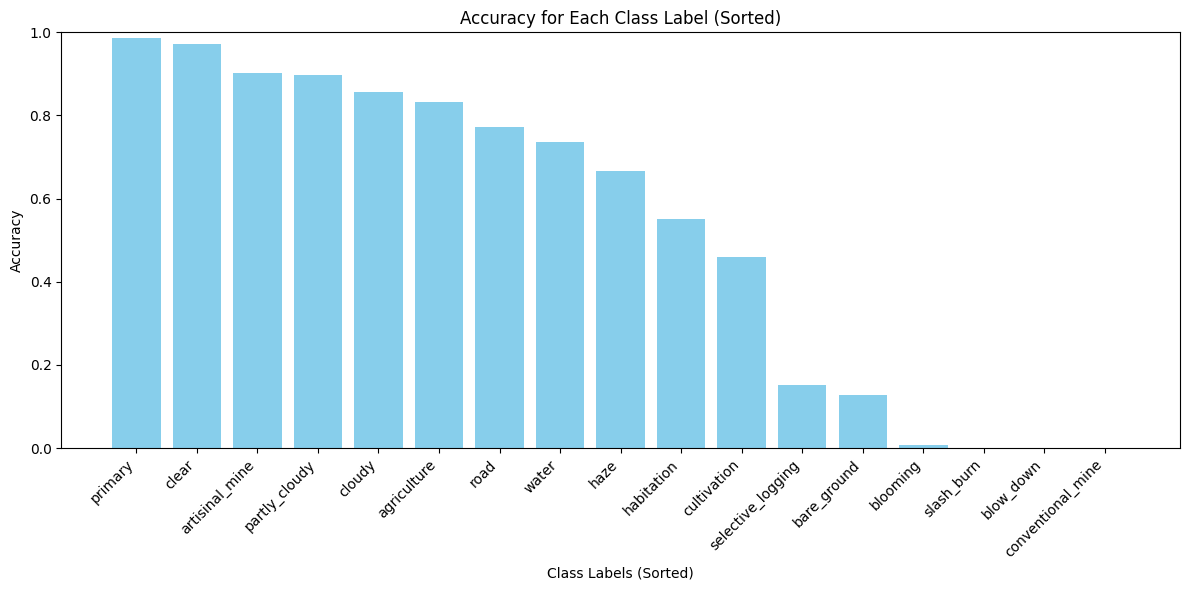

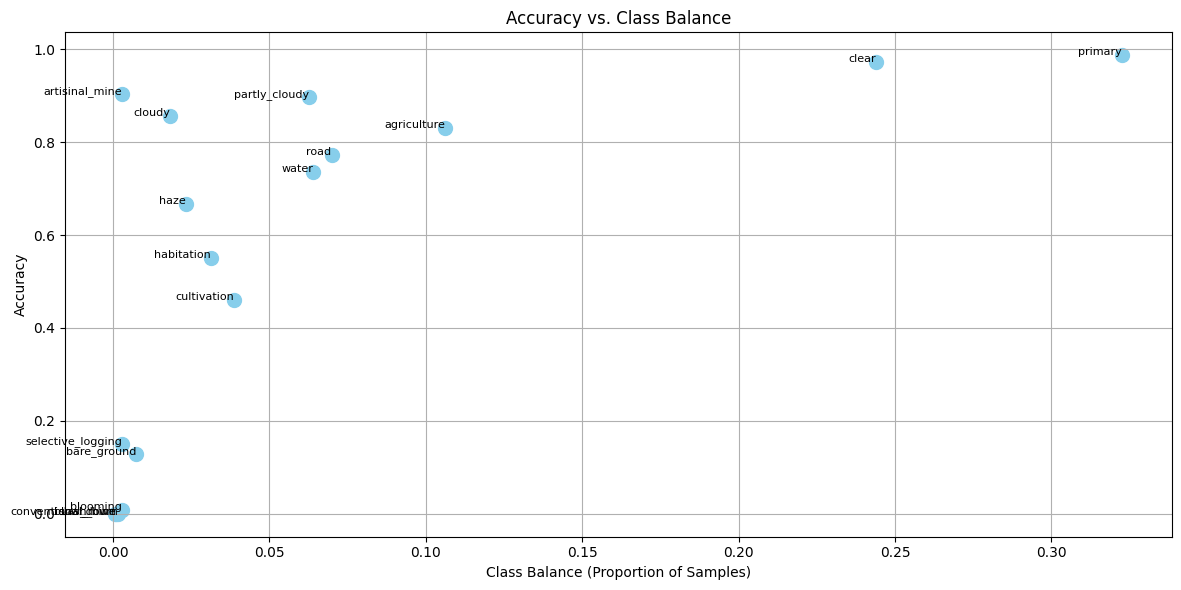

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_class_accuracy_and_balance(model, dataset, class_labels):
    """
    Calculate the accuracy and balance (class proportions) for each class label.
    Args:
        model: Trained model.
        dataset: Dataset (images and ground truth labels).
        class_labels: List of class label names.
    Returns:
        accuracies: List of accuracy values for each class.
        balances: List of class balance (proportions) for each class.
    """
    total_per_class = np.zeros(len(labels))
    correct_per_class = np.zeros(len(labels))

    # Iterate over dataset
    for images, ground_truth in dataset:
        predictions = model.predict(images)

        # turn predictions into binary
        binary_predictions = (predictions > 0.5).astype(int)

        # add to totals / correct counts
        total_per_class += np.sum(ground_truth, axis=0)
        correct_per_class += np.sum((binary_predictions == ground_truth) & (ground_truth == 1), axis=0)

    #accuracy for each class
    accuracies = correct_per_class / total_per_class

    #class balances
    balances = total_per_class / np.sum(total_per_class)

    return accuracies, balances

def plot_sorted_class_accuracy(accuracies, labels):
    """
    Plot the accuracy for each class label, sorted from highest to lowest.
    Args:
        accuracies: List of accuracy values for each class.
        class_labels: List of class label names.
    """
    # Sorting accuracies and class labels
    sorted_indices = np.argsort(accuracies)[::-1]
    sorted_accuracies = accuracies[sorted_indices]
    sorted_labels = [labels[i] for i in sorted_indices]

    plt.figure(figsize=(12, 6))
    plt.bar(sorted_labels, sorted_accuracies, color='skyblue')
    plt.xlabel("Class Labels (Sorted)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy for Each Class Label (Sorted)")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

def plot_accuracy_vs_balance(accuracies, balances, class_labels):
    """
    Plot accuracy vs. class balance for each class.
    Args:
        accuracies: List of accuracy values for each class.
        balances: List of class balance (proportions) for each class.
        class_labels: List of class label names.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(balances, accuracies, color='skyblue', s=100)

    # Annotate w/ class labels
    for i, label in enumerate(class_labels):
        plt.text(balances[i], accuracies[i], label, fontsize=8, ha='right')

    plt.xlabel("Class Balance (Proportion of Samples)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Class Balance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

accuracies, balances = calculate_class_accuracy_and_balance(model, train_dataset_numpy, labels)

# Plot sorted class accuracy
plot_sorted_class_accuracy(accuracies, labels)

# Plot accuracy vs. class balance
plot_accuracy_vs_balance(accuracies, balances, labels)

In [ ]:
# new model for just custom layers (for visual purposes only)
custom_layers_model = Model(inputs=base_model.output, outputs=model.output)
custom_layers_model.summary()

Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_178CLONE (InputLayer)   │ (None, 4, 4, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 17)                  │           4,369 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,913 (2.02 MB)

 Trainable params: 528,913 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

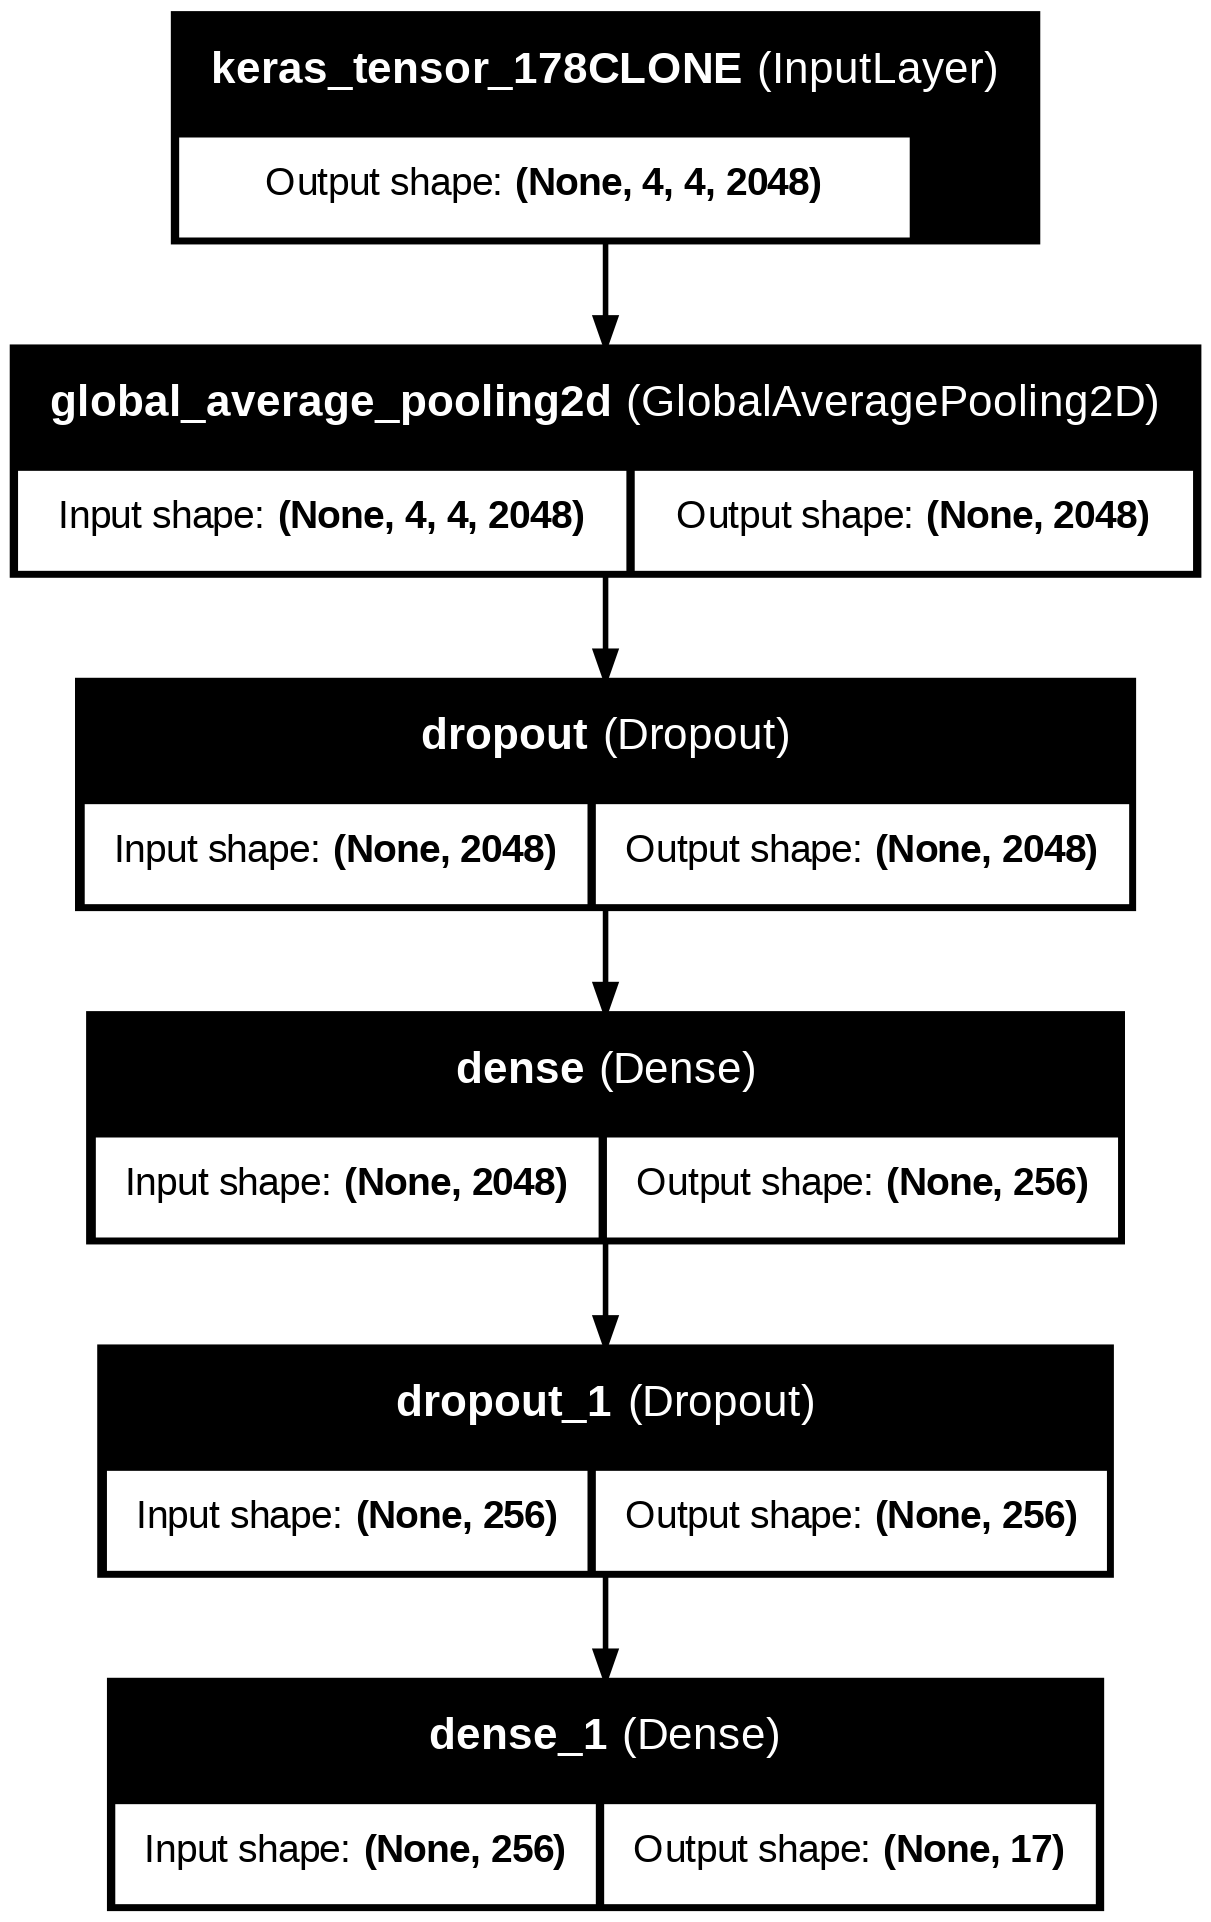

In [18]:
from tensorflow.keras.utils import plot_model

plot_model(
    custom_layers_model,
    to_file='simple_model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=300,  # Increased resolution
    rankdir='LR'
)

plot_model(custom_layers_model, to_file='simple_model_architecture.png', show_shapes=True, show_layer_names=True)